# Diversified vs. Tech Only Portfolios Analysis (ETFs)

## Project Setup

This notebook requires several Python libraries. They can be installed via:
```bash
pip install -r requirements.txt
```
Helper functions are imported from 'utils.py'

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import os
from datetime import datetime

#some functions are imported from separate utils.py for clarity of steps taken during analysis
from utils import get_data, quarterly_rebalancing, downside_deviation

#plots default styling:
plt.rcParams.update(plt.rcParamsDefault)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.left'] = False 
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['legend.frameon'] = True
plt.rcParams['legend.fancybox'] = True
plt.rcParams['legend.facecolor'] = '#D3D3D3'
%config InlineBackend.figure_format = 'retina'

## Project scope

What this project **is**:
This project is an attempt to enhance understanding of risk management and learn to visualize key performance metrics of modern portfolio theory, as well as analyze return vs risk dynamics in diversification strategy of ETFs investments. To achieve this, a comparison between portfolio consisting of tech companies only ETF (XLK) and an equal-weight, diversified by different industry sectors, ETFs portfolio is conducted. Main hypothesis of this analysis is: While a concentrated allocation to the technology sector (XLK) generated superior returns, an equal-weight diversified portfolio of major sector ETFs achieved a better risk-adjusted return with significantly lower maximum drawdown, providing sufficient resiliance to the market stress of first half of 2020 and bear market of 2022.
Area of analysis:
- Market: US
- Weights rebalancing: quarterly 
- Period: from beginning of 2014 to the end of 2024.

What this project **isn't**:
This project is not an attempt to figure out best possible portfolio for abovementioned period of time or any future period, nor exploring weight assigning methods, however it lays foundations for such work in the future.


This project did not have a concrete step by step plan at the beginning, so I invite you, dear Reader, to follow the same journey as I did.

## Data acquisition

This analysis utilizes historical price data sourced from Yahoo Finance via the yfinance Python API. While this provides easly accessible dataset for illustrative and educational purposes, it is important to note that professional financial institutions typically rely on premium data feeds from vendors like Bloomberg or Refinitiv for institutional-grade analysis.

This project is scripted in a way, so that the user can modify the tickers table below to one's liking, while keeping 'XLK' and 'SPY' in it. Following ETFs were chosen for building diversified portfolio, diversifying by industry sectors. This also applies to period (start_date, end_date), be careful though, the Efficient Frontier created at the end of the notebook is a computonally extensive process and just for the current parameters it computes in 30 minutes, any further extensiion of tickers and period will also impact this time greatly.

| Ticker | Full-name | Description | Key holdings | Theoretical advantage
| :-: | :- | :- |:- | :- |
| XLK | Technology Select Sector SPDR Fund (State Street) | The U.S. technology sector. Technology and telecom companies from the S&P 500 | Apple, Microsoft, Nvidia, Broadcom, Adobe | Pure-play, growth-oriented, high volatility |
| XLF | Financial Select Sector SPDR Fund (State Street) | The U.S. financial services sector. Banks, capital markets, insurance, and consumer finance | Berkshire Hathaway, JPMorgan Chase, Visa, Mastercard, Bank of America | Performs well in a rising interest rate environment |
| XLE | Energy Select Sector SPDR Fund (State Street) | The U.S. energy sector. Oil, gas, and consumable fuels; energy equipment & services | Exxon Mobil, Chevron, ConocoPhillips, Schlumberger | A classic diversifier against tech. Often has a low or negative correlation with XLK, strong positive correlation with oil prices |
| XLV | Health Care Select Sector SPDR Fund (State Street) | The U.S. healthcare sector. Pharmaceuticals, biotechnology, medical devices, healthcare providers | UnitedHealth Group, Johnson & Johnson, Eli Lilly, Pfizer, Abbott Labs | A defensive "recession-resistant" sector. People need healthcare regardless of the economy |
| XLI | Industrial Select Sector SPDR Fund (State Street) | The U.S. industrial sector. Aerospace, defense, machinery, road & rail, industrial conglomerates | Honeywell, Union Pacific, Boeing, Raytheon, Caterpillar | Provides exposure to domestic and global economic growth and manufacturing |
| XLP | Consumer Staples Select Sector SPDR Fund (State Street) | The U.S. consumer staples sector. Food & staples retailing, beverages, tobacco, household products | Procter & Gamble, Coca-Cola, Walmart, PepsiCo, Costco | Very defensive, stable demand, low growth |
| XLU | Utilities Select Sector SPDR Fund (State Street) | The U.S. utilities sector. Electric, gas, and water utilities, independent power producers | NextEra Energy, Southern Co, Duke Energy, Dominion Energy | Another strong defensive sector. Low growth but very low volatility |

For data acqusition, get_data() funcion is used, imported from utils.py file. It checks whether the prices data is already saved locally, if not it utilizes yahoo finance API, cleans price data and ensures proper dates formatting and saves the data.

In [2]:
#there may be any number of tickers >2, SPY and XLK must be in, diversified portfolio will be created with the remaining tickers
tickers = ['XLK', 'SPY', 'XLF', 'XLE', 'XLV', 'XLI', 'XLP', 'XLU'] 
start_date = '2014-01-01'
end_date = '2024-12-31'
prices_df = get_data(tickers, start_date, end_date)
#get_data function in utils.py
prices_df.head()

Loading data from local file...


SPY        XLE        XLF        XLI        XLK        XLP  \
Date                                                                            
2014-01-02  149.840530  56.203926  14.236197  41.767387  30.573997  31.333782   
2014-01-03  149.815994  55.997787  14.334420  41.880863  30.427132  31.274738   
2014-01-06  149.381851  56.075111  14.347518  41.637684  30.375305  31.156631   
2014-01-07  150.299271  56.500244  14.354069  41.897072  30.651747  31.326403   
2014-01-08  150.332031  56.107292  14.399901  41.824120  30.651747  31.090199   

                  XLU        XLV  
Date                              
2014-01-02  25.677317  45.763630  
2014-01-03  25.594910  45.871532  
2014-01-06  25.636116  45.680614  
2014-01-07  25.862732  46.162067  
2014-01-08  25.725388  46.568813

<Axes: title={'center': 'Cleaned Adjusted Close Prices'}, xlabel='Date', ylabel='Price'>

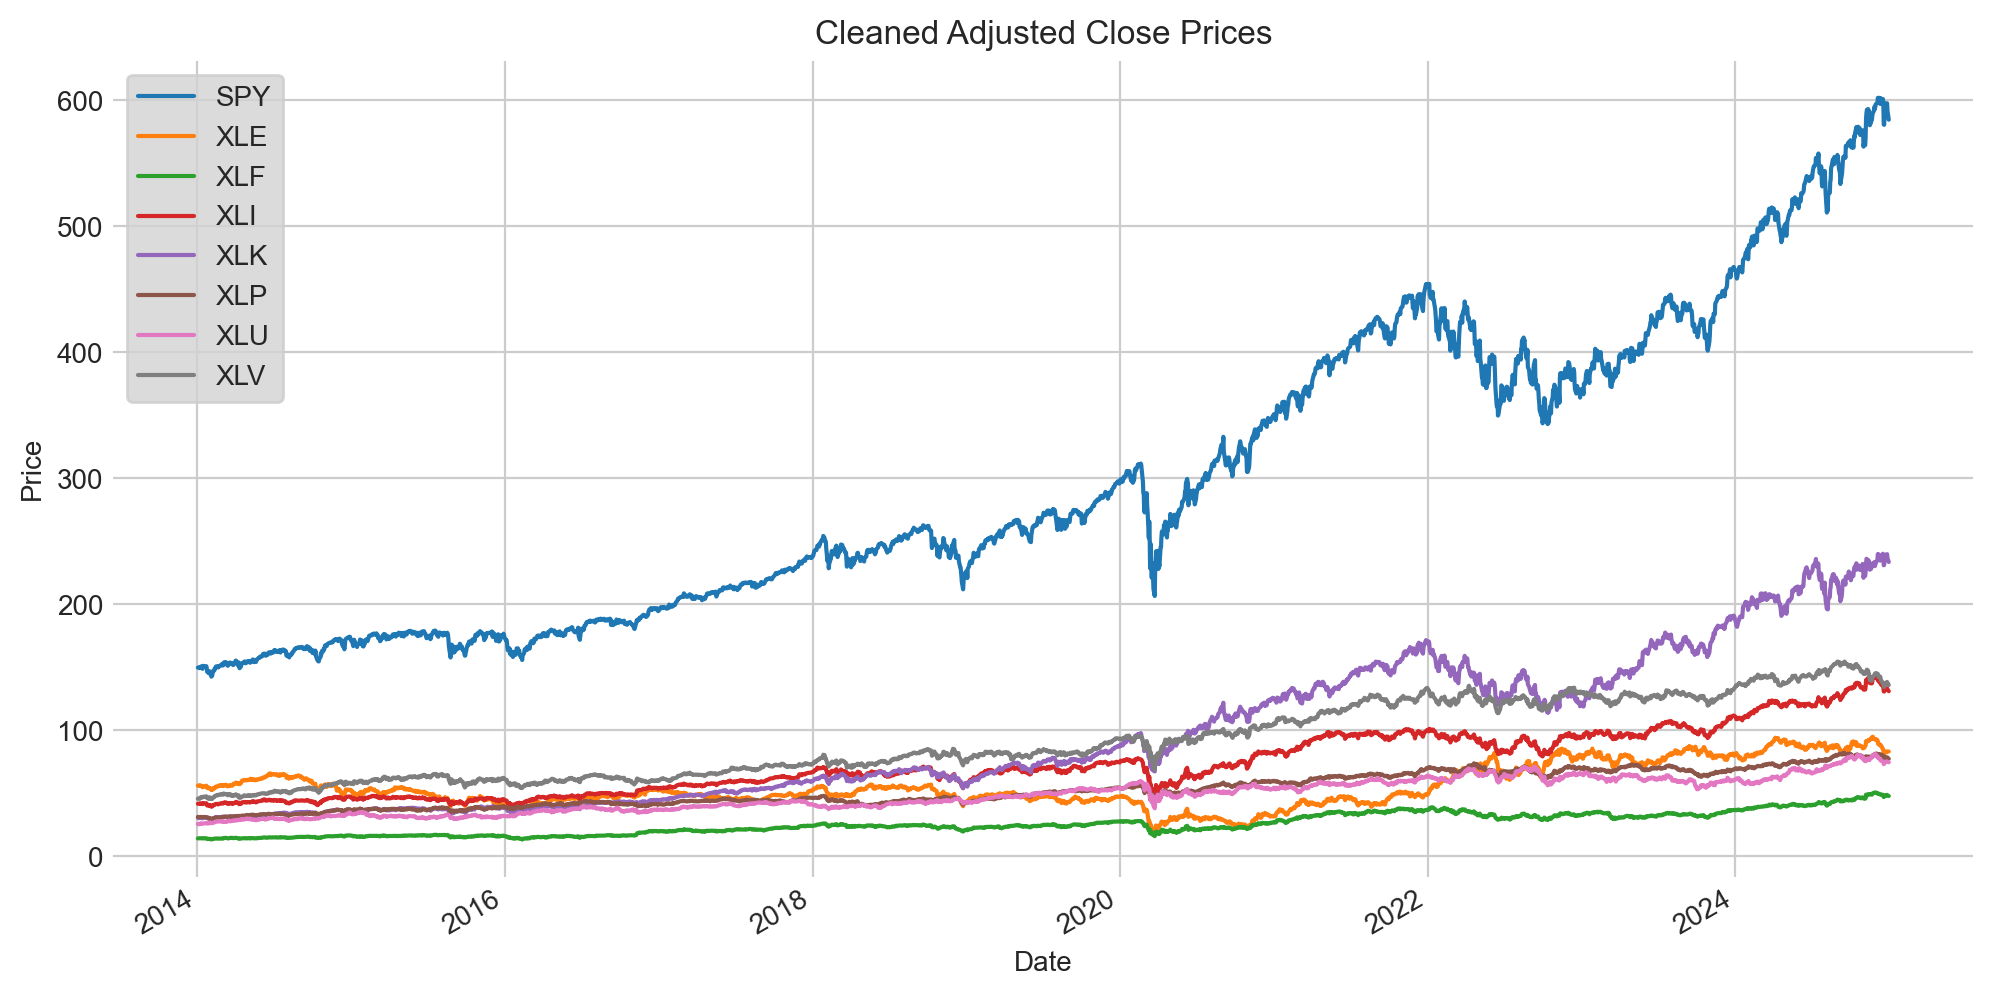

In [3]:
#plotting the data quickly to check for any outstanding issues after data cleaning:
prices_df.plot(title = 'Cleaned Adjusted Close Prices', ylabel = 'Price')

## Analysis

The calculation of daily returns and equity throughout the analyzed period were performed to begin with. The performance of the All-Tech (XLK) and market Benchmark (SPY) portfolios were calculated using a straightforward buy-and-hold strategy.

For the Diversified portfolio, a custom quarterly_rebalancing function (imported from utils.py) was used to simulate an investment strategy. This function iterates through each trading day calculating the returns. On the last trading day of each quarter, a rebalancing event is triggered:
- The total value of the portfolio is calculated,
- The difference between the current value of each asset and its target value (total portfolio value * target weight) is calculated. The sum of the absolute values of these differences represents the total amount of assets that need to be bought or sold.
- A total transaction cost is calculated by applying a small slippage percentage to this total trade value.
- The remaining capital is then redistributed according to the target weights, effectively resetting the portfolio to its desired allocation.
This is definitely not a deep dive into transaction costs calculations, rather it is a simple simulation idea I came up with to at least try to take this aspect into account while backtesting.

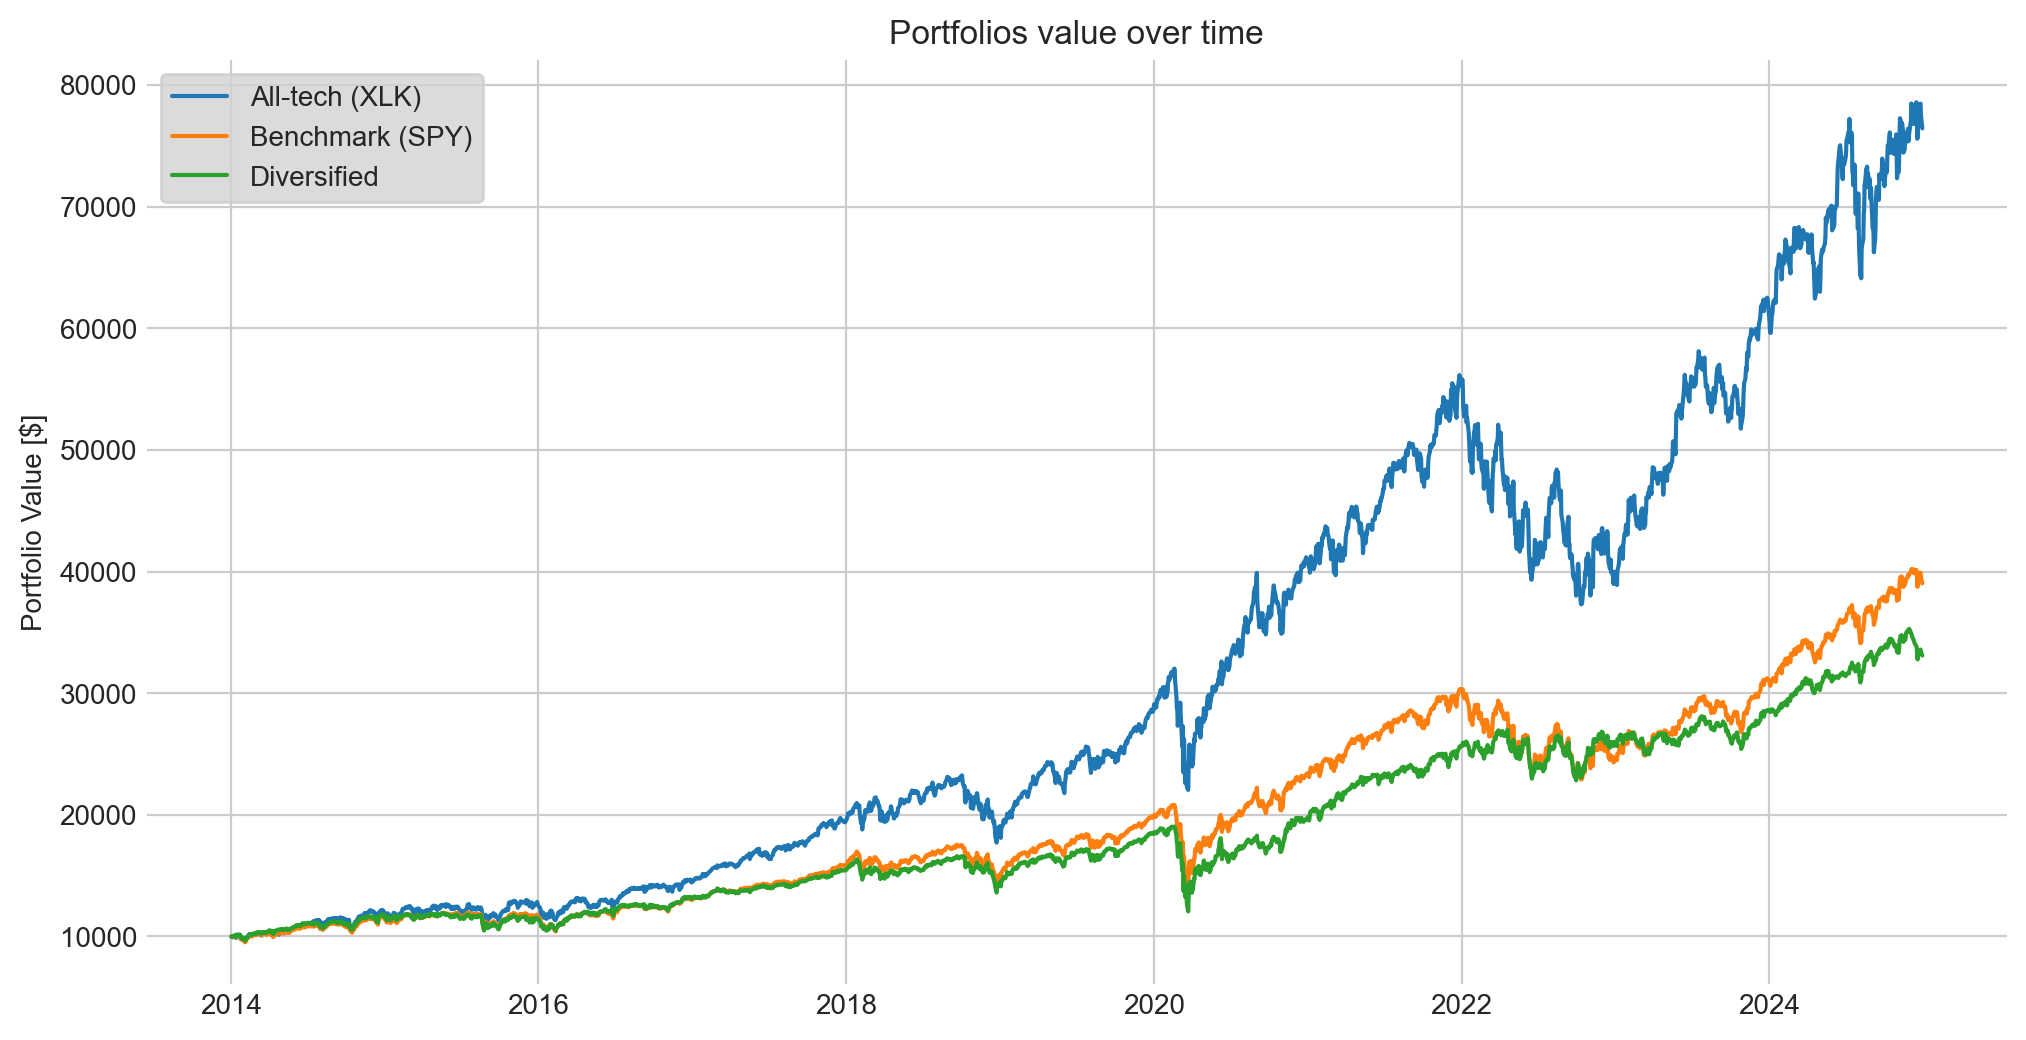

In [4]:
#daily returns for each ETF dataframe:
returns_df = prices_df.pct_change()
#without this first row of .pct_change() method would be NaN resulting in issues later:
returns_df.iloc[0] = 0
#can be any number, initial capital is just for visual purposes
initial_capital = 10000

tech_returns = returns_df['XLK']
tech_equity = (1 + tech_returns).cumprod()
tech_equity *= initial_capital

bench_returns = returns_df['SPY']
bench_equity = (1 + bench_returns).cumprod()
bench_equity *= initial_capital

#create portfolio of remaining tickers:
div_tickers = [i for i in tickers if i != 'SPY'] 
target_weights = np.array([1/len(div_tickers)] * len(div_tickers))
div_equity, div_returns = quarterly_rebalancing(returns_df, div_tickers, target_weights, initial_capital);

plt.plot(tech_equity, label = 'All-tech (XLK)')
plt.plot(bench_equity, label = 'Benchmark (SPY)')
plt.plot(div_equity, label = 'Diversified')
plt.title('Portfolios value over time')
plt.ylabel('Portfolio Value [$]')
plt.legend();

Portfolios value over time plot offers first insights to the comparison. Overall, the equal-weight diversified portfolio underperformed the concentrated Tech portfolio and the SPY benchmark in terms of absolute return over the period. We can clearly see the two critical periods: Covid crash and 2022 bear market during which from first glance the diversified portfolio seems to achieve greater resilliance to the market stress, altough not so much during Covid drawdown. Let's investigate.

In [12]:
#Compound Annual Growth Rates calculations

#calculating number of years in period, so that period can be customizable, dividing number of days total
#by number of trading days in a year rounded to 252
num_years = len(prices_df.index)/252
#this gives 10.98 years, I think it's close enough
print(num_years)
tech_cagr_pct = (tech_equity.iloc[-1]/initial_capital)**(1/num_years) - 1
bench_cagr_pct = (bench_equity.iloc[-1]/initial_capital)**(1/num_years) - 1
div_cagr_pct = (div_equity.iloc[-1]/initial_capital)**(1/num_years) - 1
print(f'CAGR for all-tech (XLK) porfolio: {tech_cagr_pct:.2%} \nCAGR for benchmark S&P500 porfolio: {bench_cagr_pct:.2%} \nCAGR for diversified porfolio: {div_cagr_pct:.2%}')

10.98015873015873
CAGR for all-tech (XLK) porfolio: 20.35% 
CAGR for benchmark S&P500 porfolio: 13.20% 
CAGR for diversified porfolio: 11.52%


The Compound Annual Growth Rates calculations allow us to move from visual observation to descriptive measurements.

- The technology sector (XLK) was the clear performance leader, achieving a remarkable 20.35% annualized return,
- The market (SPY) also performed strongly, returning 13.20%,
- The equal-weight diversified portfolio delivered a more moderate 11.52% return.

This establishes the fundamental trade-off. The concentrated tech strategy achieved superior growth but likely did so by taking on greater risk, exhibiting greater volatility. The diversified strategy sacrificed absolute return, presumably for a reduction in risk. The next steps are to quantify that risk to understand the full nature of this trade-off and whether almost two times lower returns could be somehow justified.

In [13]:
#returns volatility calculations
tech_daily_volatility = tech_returns.std()
bench_daily_volatility = bench_returns.std()
div_daily_volatility = div_returns.std()

tech_annual_volatility = tech_daily_volatility * np.sqrt(252)
bench_annual_volatility = bench_daily_volatility * np.sqrt(252)
div_annual_volatility = div_daily_volatility * np.sqrt(252)

print(f'Annual volatility for all-tech (XLK) portfolio: {tech_annual_volatility:.2%} \nAnnual volatility for benchmark S&P500 portfolio: {bench_annual_volatility:.2%} \nAnnual volatility for diversified portfolio: {div_annual_volatility:.2%}')

Annual volatility for all-tech (XLK) portfolio: 22.54% 
Annual volatility for benchmark S&P500 portfolio: 17.13% 
Annual volatility for diversified portfolio: 16.35%


The annualized volatility figures quantify the risk dimension of the trade-off. The tech portfolio was significantly more volatile (23%) than both the broad market (17%) and the diversified portfolio (16%). While the strong positive return suggests a favorable distribution overall, the distribution plot will reveal the structure of this volatility, specifically, the moves in both directions, which is a key characteristic of high-risk, high-reward assets.

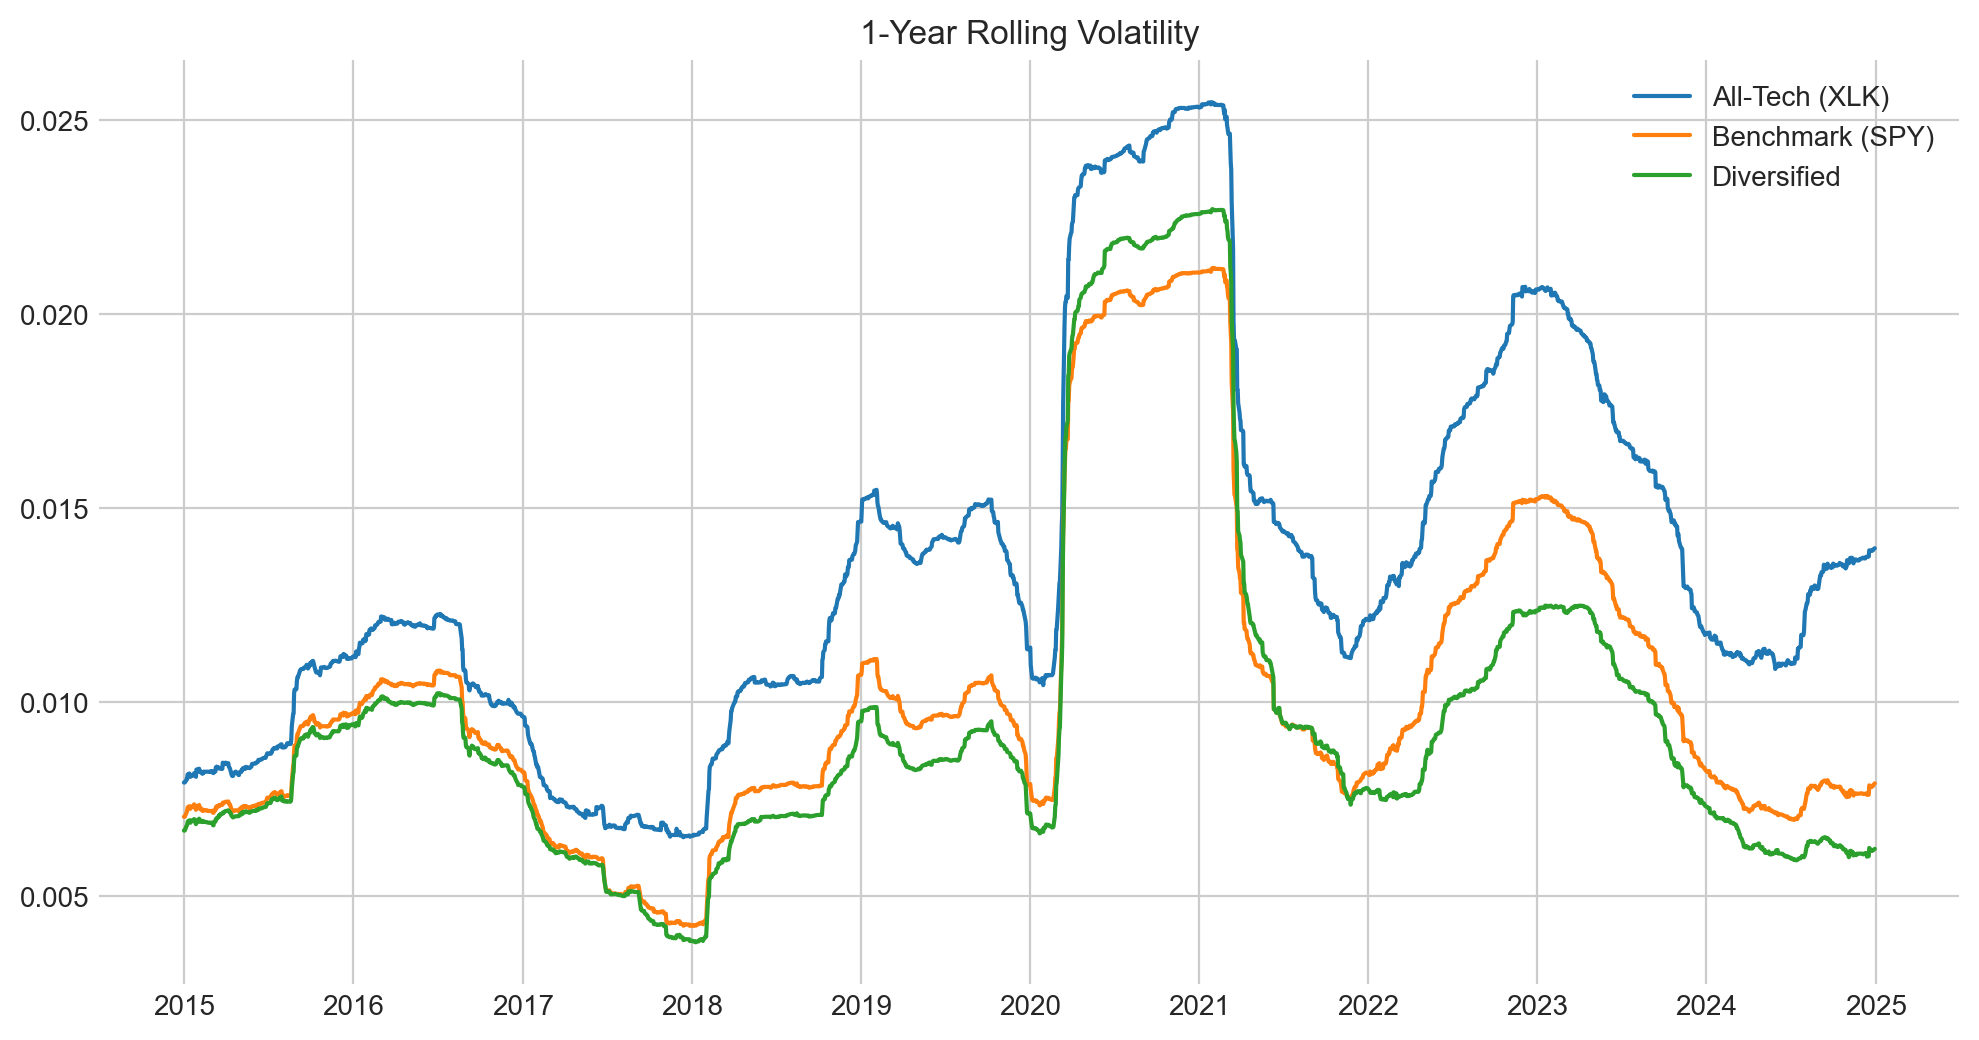

In [7]:
tech_rolling_volatility = tech_returns.rolling(252).std()
bench_rolling_volatility = bench_returns.rolling(252).std()
div_rolling_volatility = div_returns.rolling(252).std()

plt.plot(tech_rolling_volatility, label = 'All-Tech (XLK)')
plt.plot(bench_rolling_volatility, label = 'Benchmark (SPY)')
plt.plot(div_rolling_volatility, label = 'Diversified')
plt.title('1-Year Rolling Volatility')
plt.legend();
plt.show()

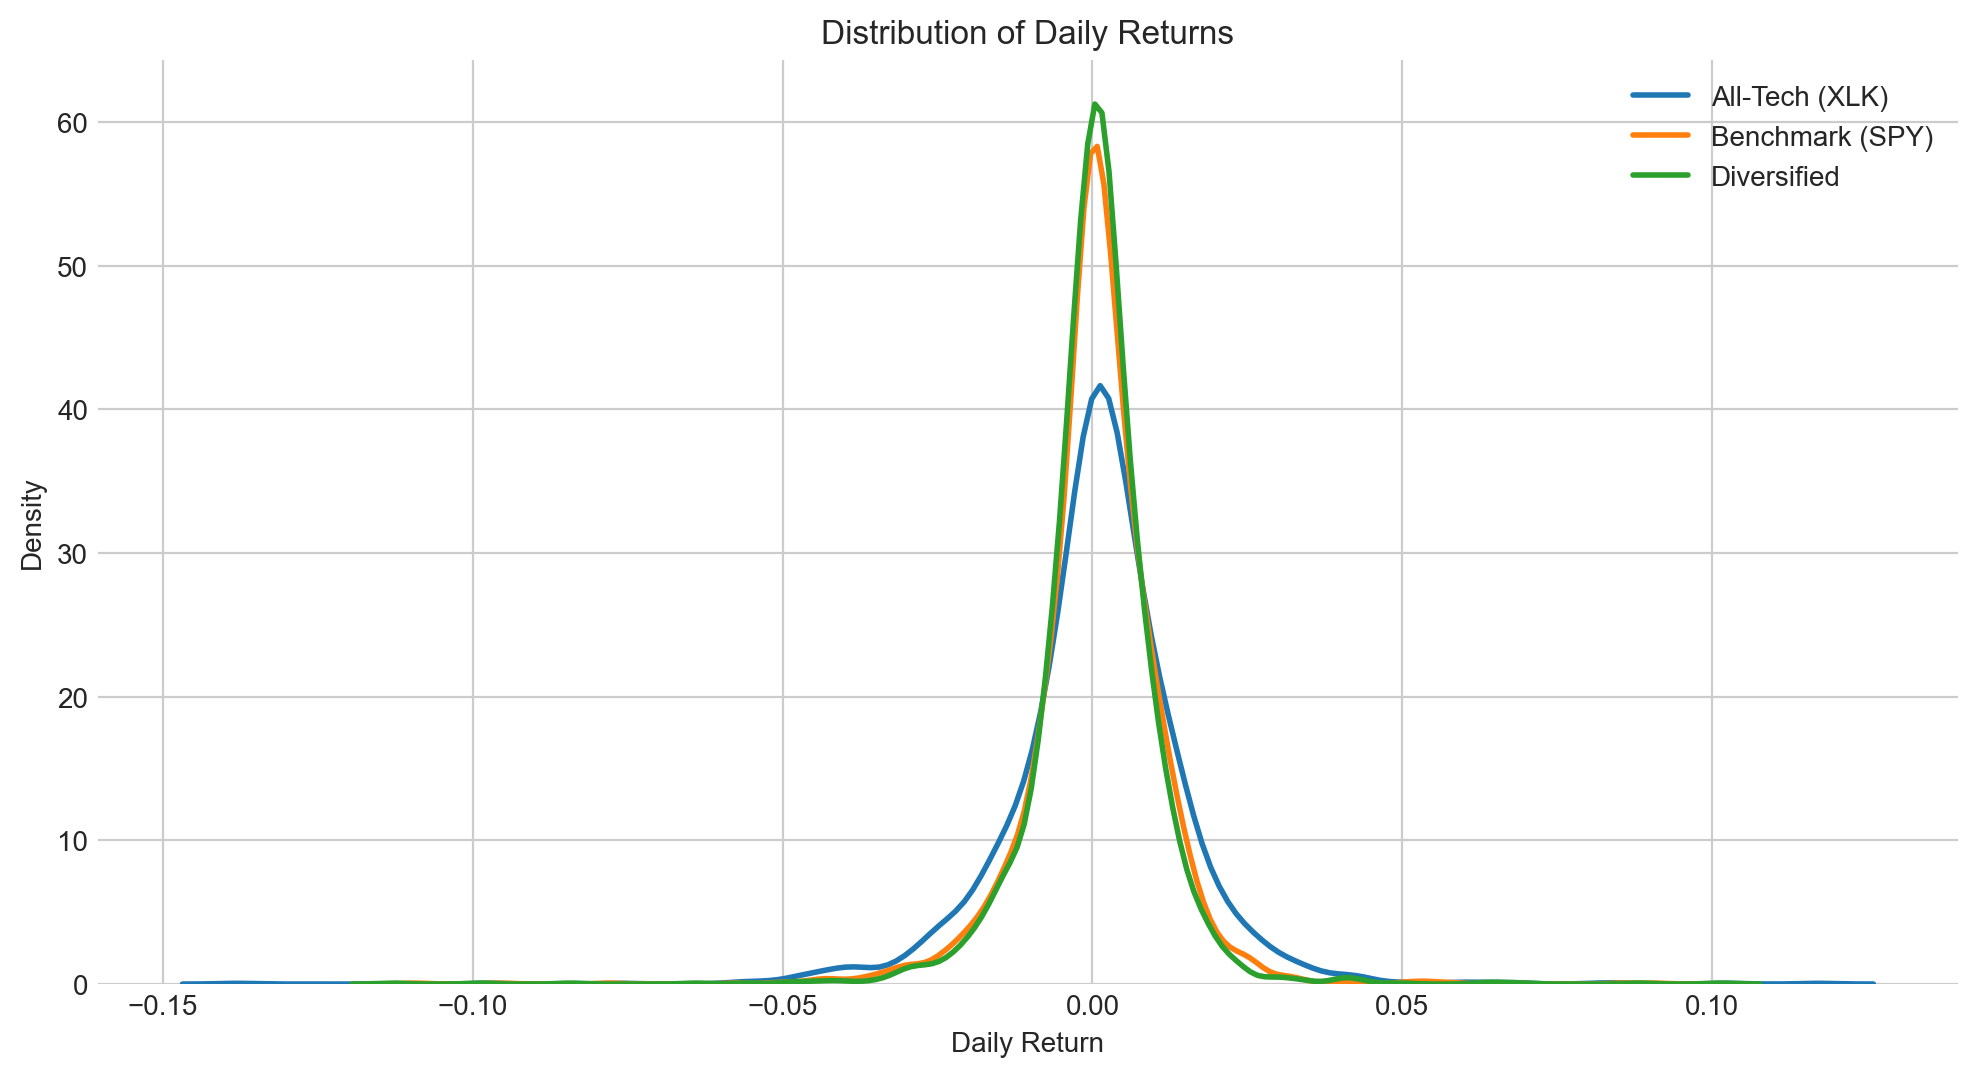

In [8]:
sns.kdeplot(tech_returns, label='All-Tech (XLK)', linewidth = 2)
sns.kdeplot(bench_returns, label='Benchmark (SPY)', linewidth = 2)
sns.kdeplot(div_returns, label='Diversified', linewidth = 2)

plt.title('Distribution of Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Density')
plt.legend()
plt.show()

Distribution plot sort of completes the picture that the numbers began to draw. All three have a positive skew, just confirming what we already knew from the strong overall performance. However, for the tech portfolio, this positive skew is paired with fat tails. This combination is the statistical signature of many small-to-moderate gains, punctuated by a few bigger gains and losses. The diversified portfolio's thinner tails indicate a more predictable profile. 
To quantify the worst-case losses experienced by an investor, let's calculate the Maximum Drawdown for each portfolio. This measures the largest peak-to-trough decline from the equity curve's running maximum. 

In [9]:
#Maximum Drawdown calculations:
tech_equity_runnimg_max = tech_equity.cummax()
tech_dd_series = (tech_equity/tech_equity_runnimg_max) - 1
tech_max_dd = tech_dd_series.min()

bench_equity_runnimg_max = bench_equity.cummax()
bench_dd_series = (bench_equity/bench_equity_runnimg_max) - 1
bench_max_dd = bench_dd_series.min()

div_equity_runnimg_max = div_equity.cummax()
div_dd_series = (div_equity/div_equity_runnimg_max) - 1
div_max_dd = div_dd_series.min()

print(f'Maximum Drawdown for all-tech (XLK) porfolio: {tech_max_dd:.2%}\nMaximum Drawdown for benchmark S&P500 porfolio: {bench_max_dd:.2%}\nMaximum Drawdown for diversified porfolio: {div_max_dd:.2%}')

Maximum Drawdown for all-tech (XLK) porfolio: -33.56%
Maximum Drawdown for benchmark S&P500 porfolio: -33.72%
Maximum Drawdown for diversified porfolio: -36.62%


Results are are quite suprising, turns out diversified portfolio experienced largest Maximum Drawdown of the group. Let's plot the drawdown series for each portfolio and zoom in on specific stress period during which drawdowns are expected to be the largest to draw deeper conlcusions.

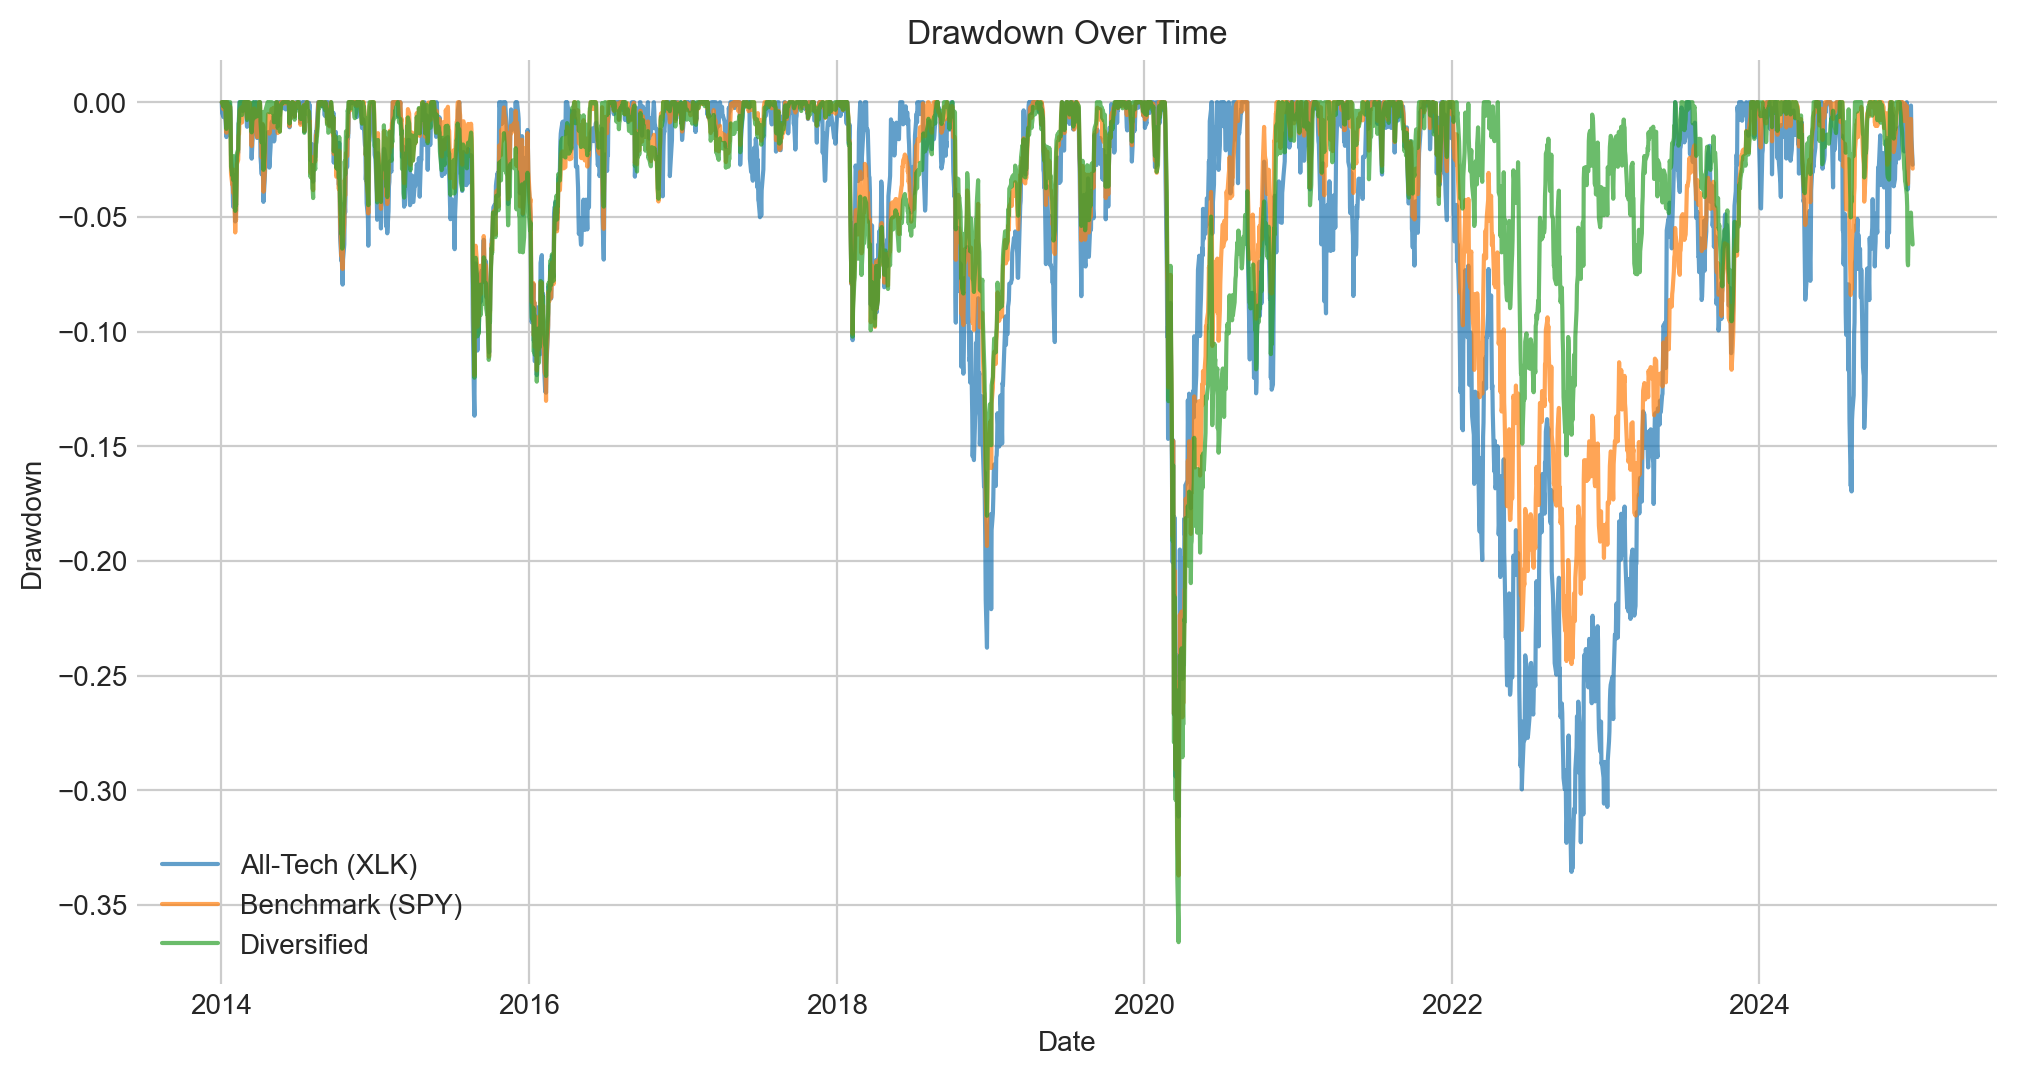

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(tech_dd_series, label='All-Tech (XLK)', alpha=0.7)
plt.plot(bench_dd_series, label='Benchmark (SPY)', alpha=0.7)
plt.plot(div_dd_series, label='Diversified', alpha=0.7)

plt.title('Drawdown Over Time')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.show()

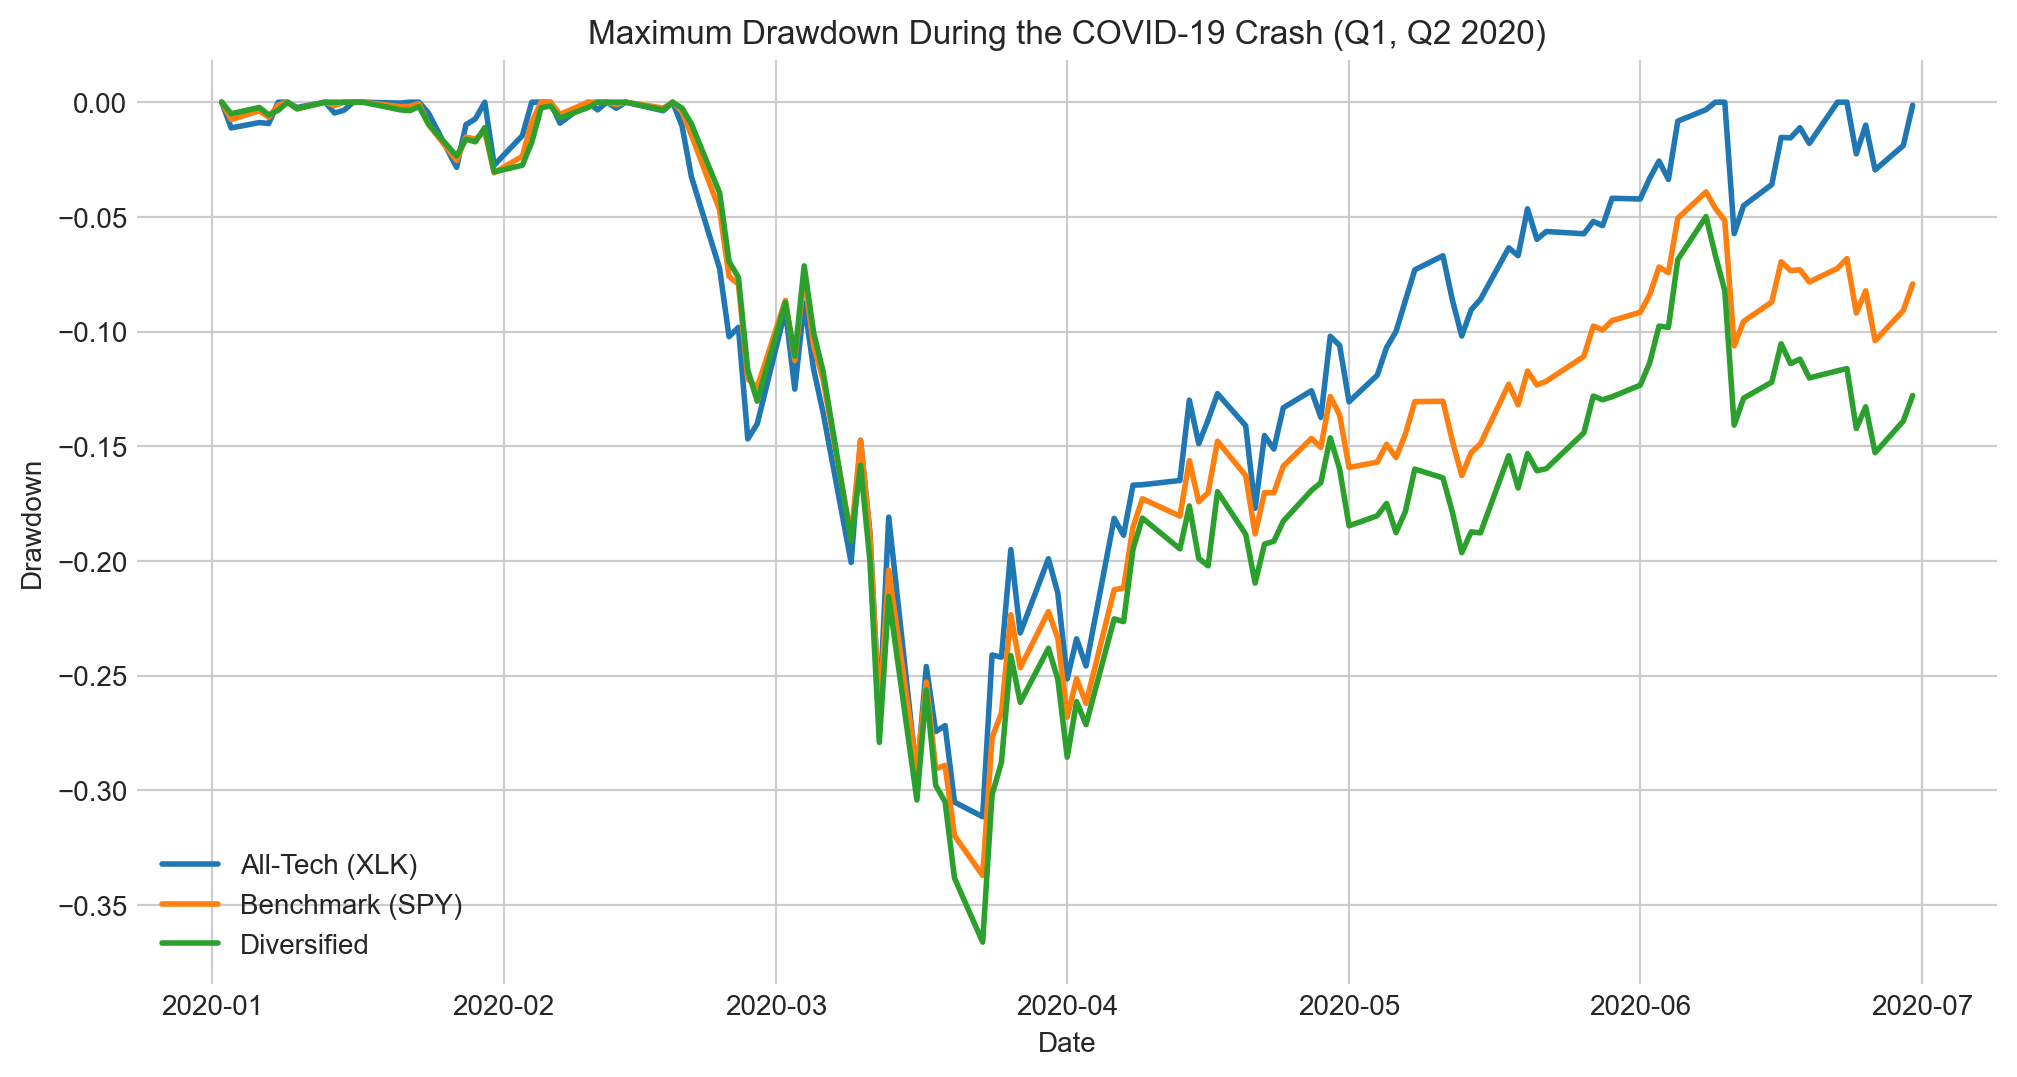

In [11]:
drawdown_series = pd.DataFrame({
    'tech_dd': tech_dd_series,
    'bench_dd': bench_dd_series,
    'div_dd': div_dd_series
})

mask_h1_2020 = (drawdown_series.index >= '2020-01-01') & (drawdown_series.index < '2020-07-01') #mask for the first half of 2020
dd_h1_2020 = drawdown_series.loc[mask_h1_2020]

plt.plot(dd_h1_2020['tech_dd'], label='All-Tech (XLK)', linewidth=2)
plt.plot(dd_h1_2020['bench_dd'], label='Benchmark (SPY)', linewidth=2)
plt.plot(dd_h1_2020['div_dd'], label='Diversified', linewidth=2)

plt.title('Maximum Drawdown During the COVID-19 Crash (Q1, Q2 2020)')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

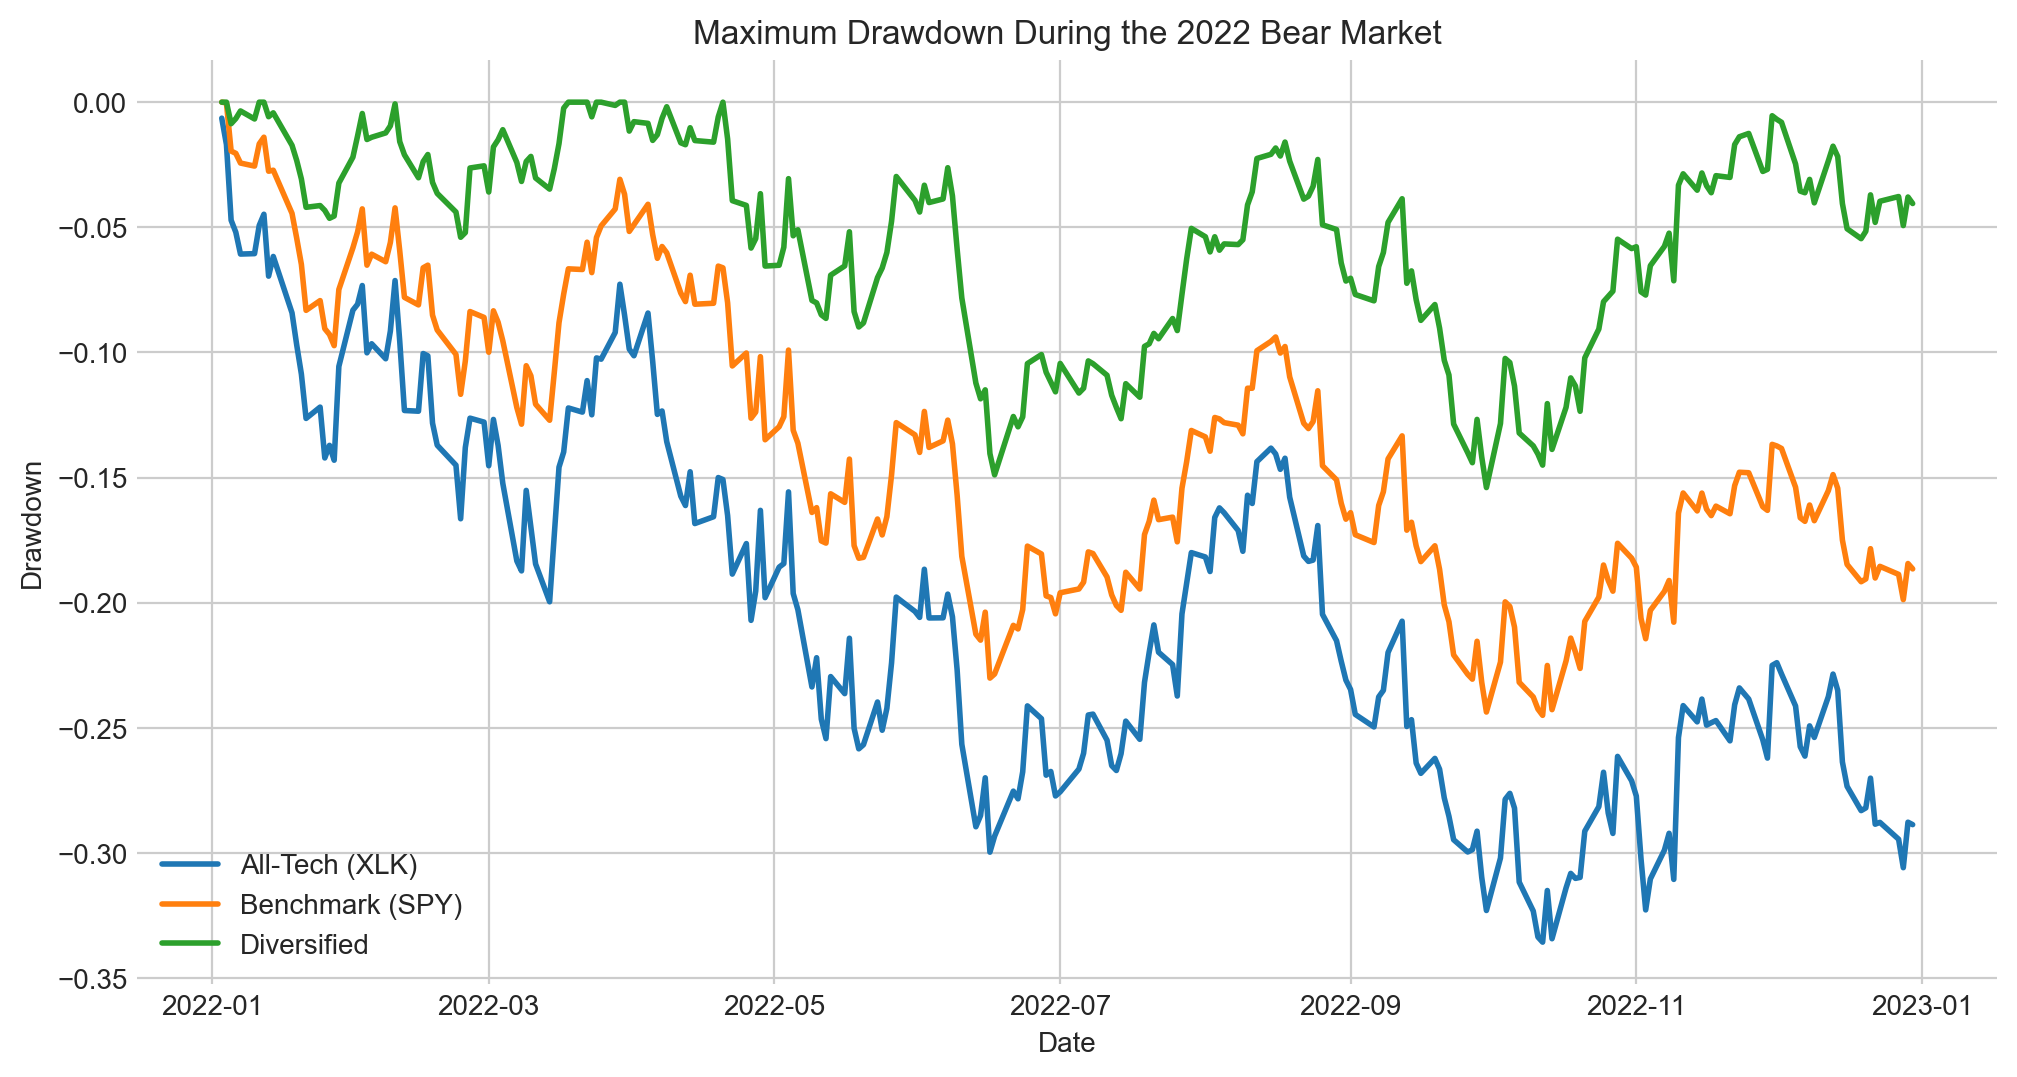

In [12]:
mask_2022 = (drawdown_series.index >= '2022-01-01') & (drawdown_series.index < '2023-01-01') #mask to filter for dates in 2022
dd_2022 = drawdown_series.loc[mask_2022]

plt.plot(dd_2022['tech_dd'], label='All-Tech (XLK)', linewidth=2)
plt.plot(dd_2022['bench_dd'], label='Benchmark (SPY)', linewidth=2)
plt.plot(dd_2022['div_dd'], label='Diversified', linewidth=2)

plt.title('Maximum Drawdown During the 2022 Bear Market')
plt.ylabel('Drawdown')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

Surprisingly, the Maximum Drawdowns for the all-tech and diversified portfolios occurred in different periods. The diversified portfolio's worst loss happened during the COVID-19 crash. This illustrates a key limitation of diversification: during a true systemic crisis that impacts all sectors simultaneously, such as the sudden supply chain, demand, and operational shocks seen in 2020, correlations between assets can converge toward 1. This means even a well-diversified portfolio may not provide protection, as seen in the sharp, simultaneous decline across industrial, consumer, and other sectors. 
This stands in contrast to the tech portfolio's maximum drawdown, which occurred later, during the 2022 bear market. This period was driven not by a universal shock, but by idiosyncratic risks—risks specific to particular sectors or factors. The 2022 bear market was primarily caused by central banks raising interest rates to combat inflation. This is a macroeconomic policy risk that affects sectors very differently:
- High-growth, long-duration assets like technology stocks (XLK) are severely impacted, as their valuations are more sensitive to higher discount rates,
- Defensive sectors like Utilities (XLU) and Consumer Staples (XLP), which are less rate-sensitive, provided stability,
- Energy (XLE) even benefited from the inflationary environment.
Next, we will take a closer look at the risk vs return dynamics by comparing key metrics such us Sharpe Ratio and Sortino Ratio. For risk-free rate, a 10-year US treasury bond rates were used.

In [13]:
#Sharpe Ratio calculations:
tech_annualized_return = (1 + tech_returns.mean()) ** 252 - 1 #geometric annualized portfolio return for Sharpe Ratio calc
bench_annualized_return = (1 + bench_returns.mean()) ** 252 - 1
div_annualized_return = (1 + div_returns.mean()) ** 252 - 1

print(f'Average annual return on all-tech (XLK) portfolio: {tech_annualized_return:.2%} \nAverage annual return on benchmark (SPY) portfolio: {bench_annualized_return:.2%} \nAverage annual return on diversified portfolio: {div_annualized_return:.2%}')

Average annual return on all-tech (XLK) portfolio: 23.45% 
Average annual return on benchmark (SPY) portfolio: 14.88% 
Average annual return on diversified portfolio: 13.02%


In [14]:
#10-year US treasury bond daily rate download
TNX = yf.download('^TNX', start = start_date, end = end_date, auto_adjust = False)['Close']
TNX = TNX.sort_index()
TNX.head()

[*********************100%***********************]  1 of 1 completed


Ticker       ^TNX
Date             
2014-01-02  2.985
2014-01-03  2.995
2014-01-06  2.961
2014-01-07  2.937
2014-01-08  2.993

In [15]:
#Sharpe Ratio calculations continued:
average_tnx_yield = TNX.mean().iloc[0]/100

tech_sharpe = (tech_annualized_return - average_tnx_yield)/tech_annual_volatility
bench_sharpe = (bench_annualized_return - average_tnx_yield)/bench_annual_volatility
div_sharpe = (div_annualized_return - average_tnx_yield)/div_annual_volatility

print(f'Sharpe Ratio for all-tech (XLK) portfolio: {tech_sharpe:.2} \nSharpe Ratio for benchmark (SPY) portfolio: {bench_sharpe:.2} \nSharpe Ratio for diversified portfolio: {div_sharpe:.2}')

Sharpe Ratio for all-tech (XLK) portfolio: 0.93 
Sharpe Ratio for benchmark (SPY) portfolio: 0.72 
Sharpe Ratio for diversified portfolio: 0.64


In [16]:
#Sortino Ratio calculations:
MAR = average_tnx_yield #define minimum acceptable return, decimal
tech_excess_returns = tech_returns - MAR
bench_excess_returns = bench_returns - MAR
div_excess_returns = div_returns - MAR

tech_downside_returns = tech_excess_returns[tech_excess_returns < 0]
bench_downside_returns = bench_excess_returns[bench_excess_returns < 0]
div_downside_returns = div_excess_returns[div_excess_returns < 0]

tech_downside_deviation_annualized = tech_downside_returns.std() * np.sqrt(252)
bench_downside_deviation_annualized = bench_downside_returns.std() * np.sqrt(252)
div_downside_deviation_annualized = div_downside_returns.std() * np.sqrt(252)

tech_sortino = (tech_annualized_return - average_tnx_yield)/tech_downside_deviation_annualized
bench_sortino = (bench_annualized_return - average_tnx_yield)/bench_downside_deviation_annualized
div_sortino = (div_annualized_return - average_tnx_yield)/div_downside_deviation_annualized

print(f'Sortino Ratio for all-tech (XLK) portfolio: {tech_sortino:.2} \nSortino Ratio for benchmark (SPY) portfolio: {bench_sortino:.2} \nSortino Ratio for diversified portfolio: {div_sortino:.2}')

Sortino Ratio for all-tech (XLK) portfolio: 1.1 
Sortino Ratio for benchmark (SPY) portfolio: 0.79 
Sortino Ratio for diversified portfolio: 0.71


The all-tech portfolio (XLK) demonstrated superior risk-adjusted performance, with a Sharpe ratio of 0.93 that significantly outpaced the diversified portfolio's 0.64, which is even worse than the market during that period. More importantly, the gap between its Sortino ratio (1.10) and Sharpe ratio reveals that a substantial portion of the tech portfolio's total volatility was actually 'good' volatility from upside moves. This created a favorably skewed return profile. In contrast, the diversified portfolio's ratios are much closer together, confirming its more symmetrical and predictable, though much less profitable. Let's actually see 12-Month rolling plots of these metrics.

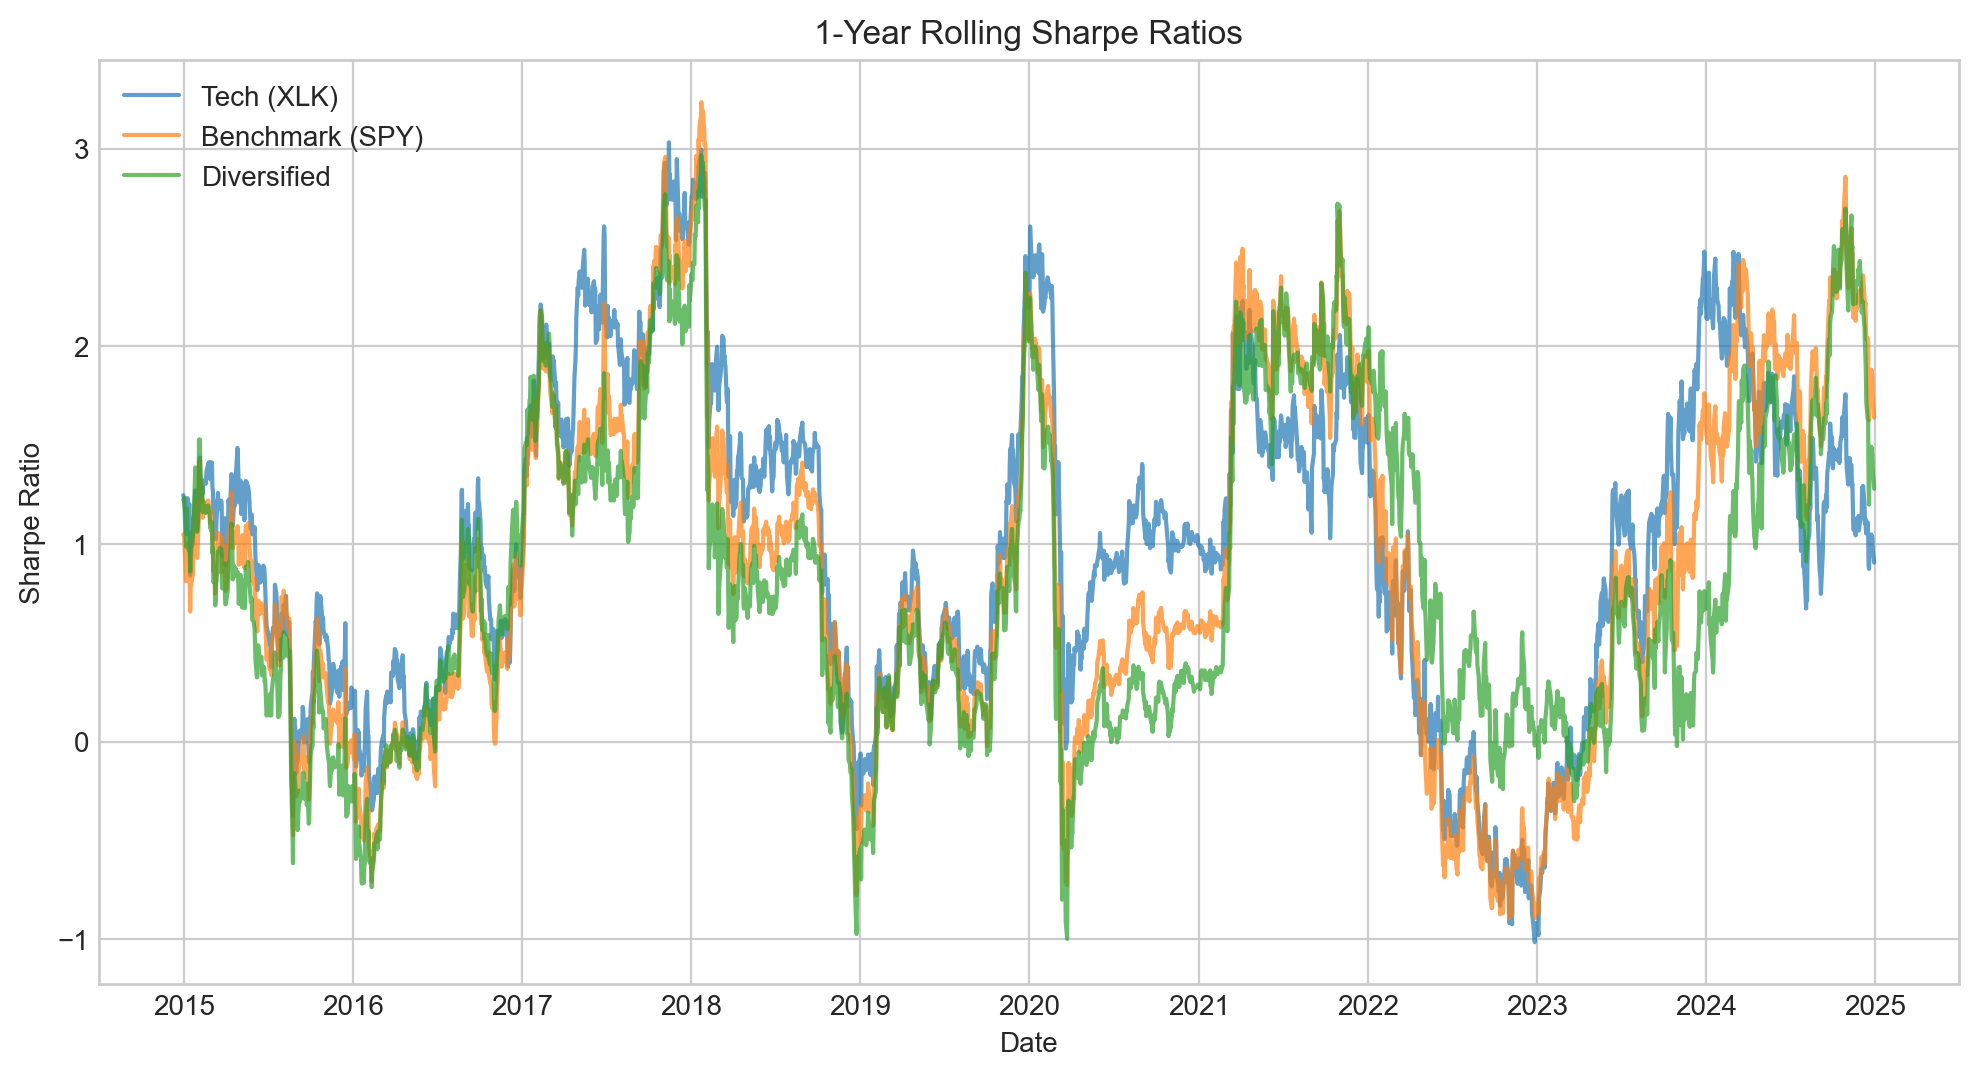

In [63]:
#rolling Sharpe Ratios calculations
tech_rolling_returns = tech_returns.rolling(252)
bench_rolling_returns = bench_returns.rolling(252)
div_rolling_returns = div_returns.rolling(252)

tech_rolling_sharpe = (tech_rolling_returns.mean() * 252 - average_tnx_yield)/(tech_rolling_returns.std()*np.sqrt(252))
bench_rolling_sharpe = (bench_rolling_returns.mean() * 252 - average_tnx_yield)/(bench_rolling_returns.std()*np.sqrt(252))
div_rolling_sharpe = (div_rolling_returns.mean() * 252 - average_tnx_yield)/(div_rolling_returns.std()*np.sqrt(252))

plt.plot(tech_rolling_sharpe, label='Tech (XLK)', alpha = 0.7)
plt.plot(bench_rolling_sharpe, label='Benchmark (SPY)', alpha = 0.7)
plt.plot(div_rolling_sharpe, label='Diversified', alpha = 0.7)
plt.title('1-Year Rolling Sharpe Ratios')
plt.ylabel('Sharpe Ratio')
plt.xlabel('Date')
plt.legend()
plt.show()

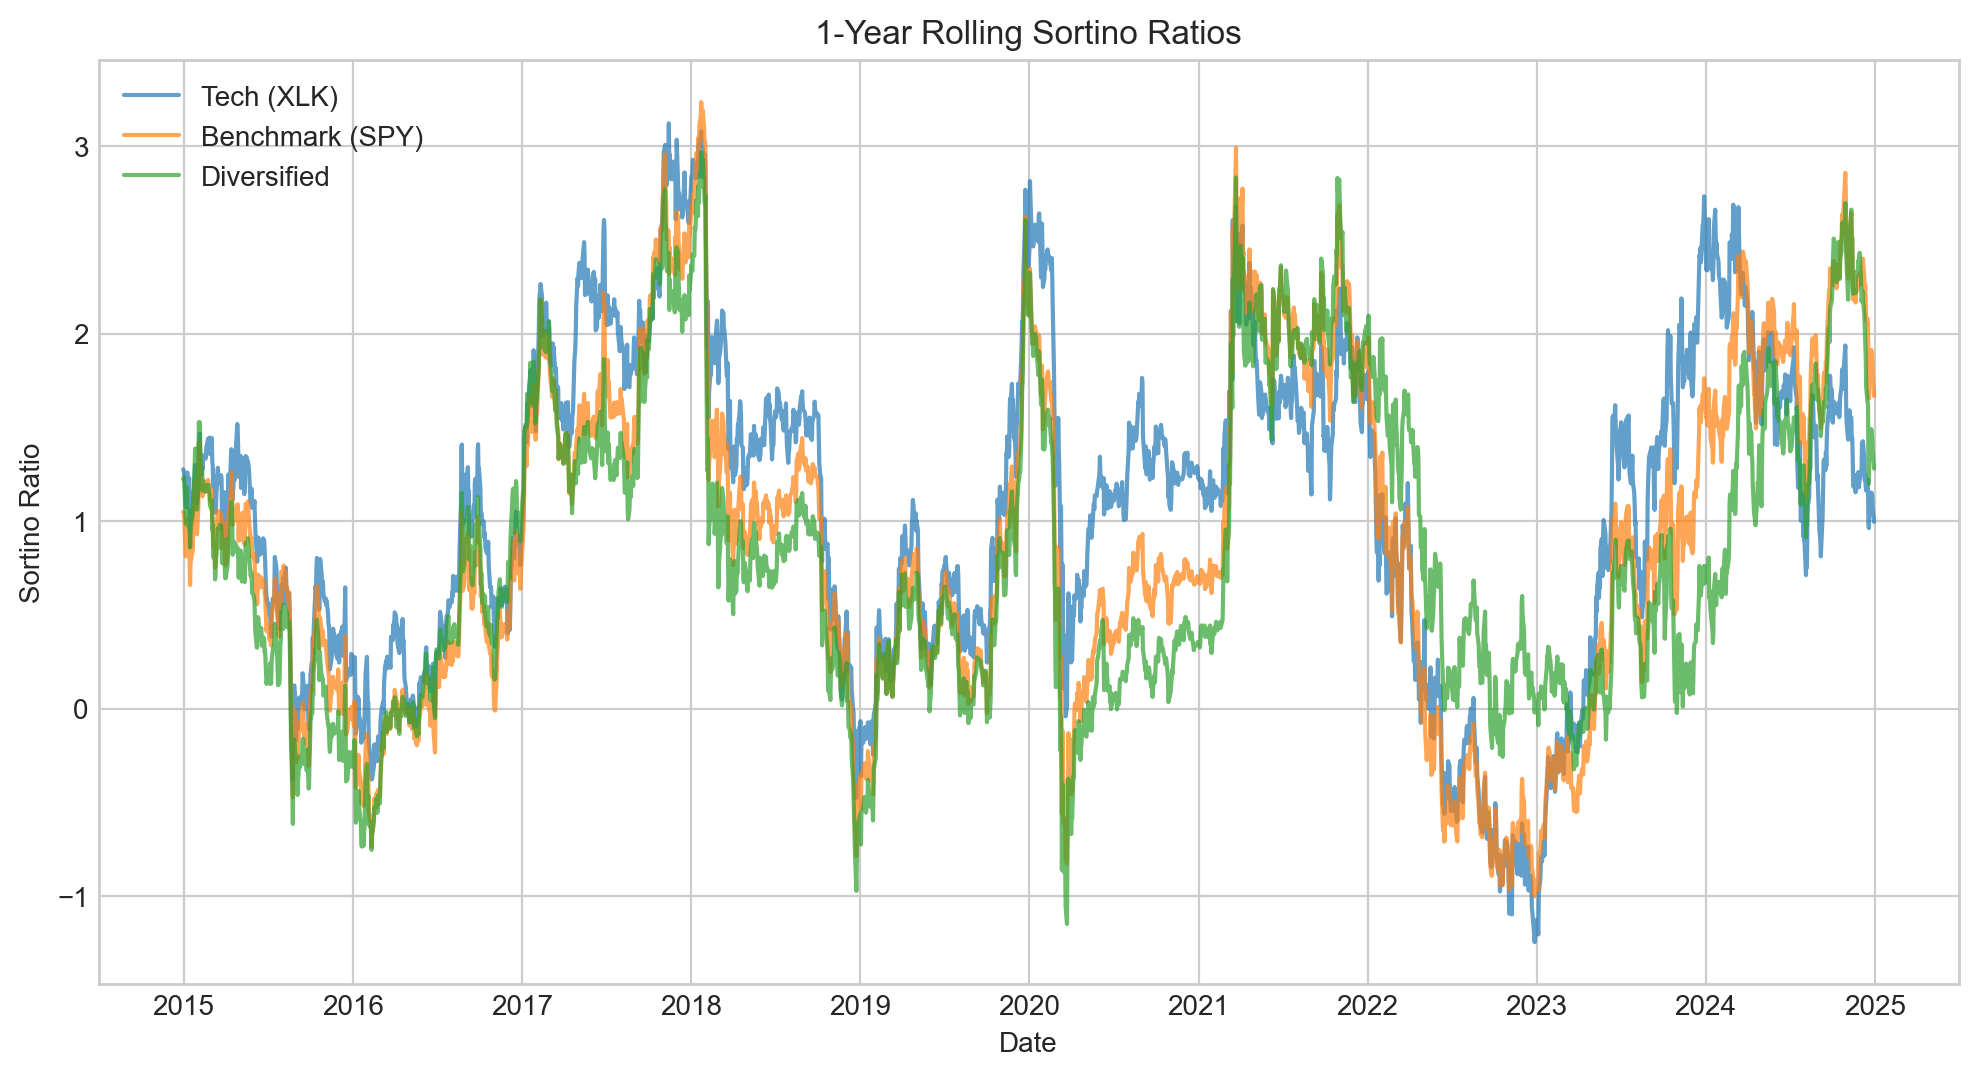

In [64]:
#rolling Sortino Ratios calculations
tech_rolling_downside_deviation = tech_rolling_returns.apply(lambda x: downside_deviation(x, MAR))
bench_rolling_downside_deviation = bench_rolling_returns.apply(lambda x: downside_deviation(x, MAR))
div_rolling_downside_deviation = div_rolling_returns.apply(lambda x: downside_deviation(x, MAR))

tech_rolling_sortino = (tech_rolling_returns.mean() * 252 - average_tnx_yield)/(tech_rolling_downside_deviation * np.sqrt(252))
bench_rolling_sortino = (bench_rolling_returns.mean() * 252 - average_tnx_yield)/(bench_rolling_downside_deviation * np.sqrt(252))
div_rolling_sortino = (div_rolling_returns.mean() * 252 - average_tnx_yield)/(div_rolling_downside_deviation * np.sqrt(252))

plt.plot(tech_rolling_sortino, label='Tech (XLK)', alpha = 0.7)
plt.plot(bench_rolling_sortino, label='Benchmark (SPY)', alpha = 0.7)
plt.plot(div_rolling_sortino, label='Diversified', alpha = 0.7)
plt.title('1-Year Rolling Sortino Ratios')
plt.ylabel('Sortino Ratio')
plt.xlabel('Date')
plt.legend()
plt.show()

The rolling analysis reveals that the leadership in risk-adjusted returns was not constant. The technology portfolio maintained higher ratios throughout the extended bull market. However, a notable regime shift occurred during the 2022 bear market, where the diversified portfolio's rolling Sharpe and Sortino ratios exceeded those of the tech portfolio for a sustained period.
This demonstrates that the benefit of the diversified strategy was conditional on the market environment. It did not offer superior average efficiency, but it provided a specific advantage during a market downturn driven by sector-specific pressures, which aligns with the theoretical goal of diversification. 
 

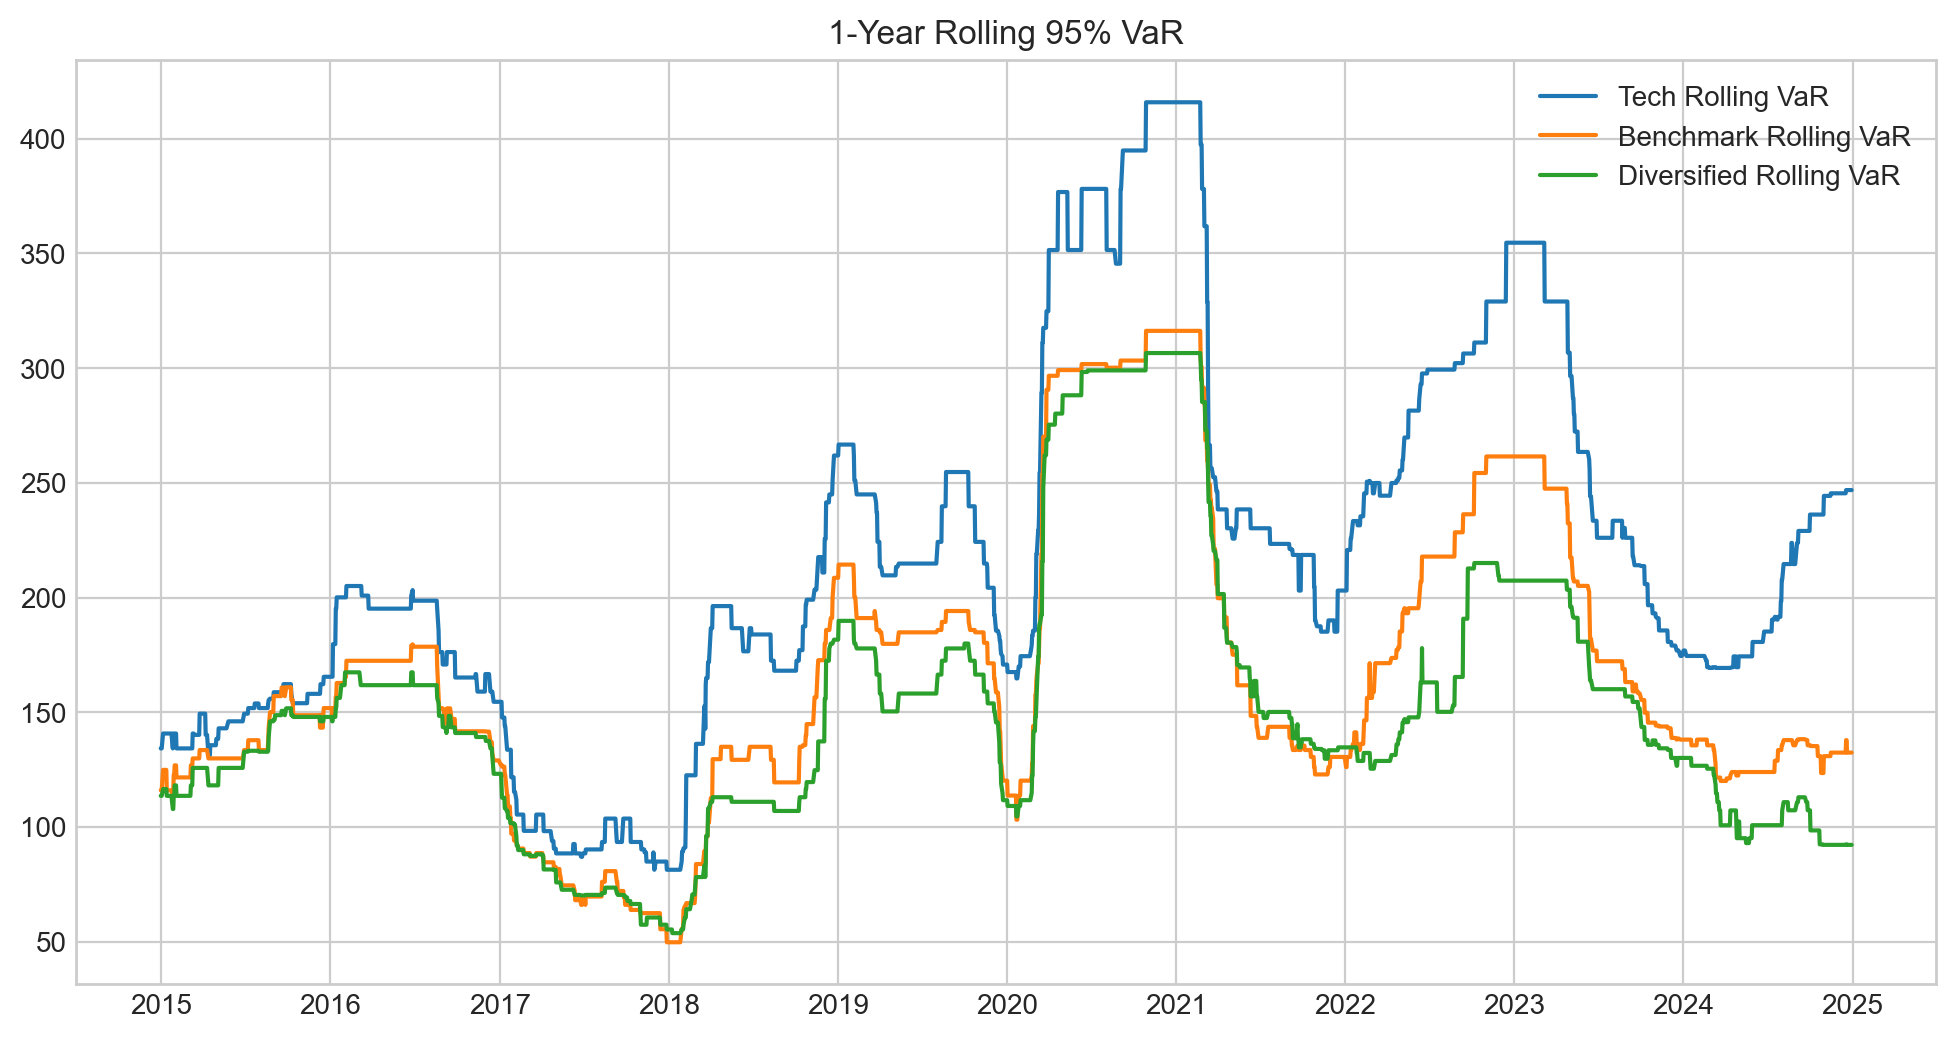

In [65]:
#historical VaR
tech_rolling_VaR = initial_capital * tech_returns.rolling(252).apply(lambda x: -np.percentile(x, 5)) #using minus to convert negative returns to value at risk
bench_rolling_VaR = initial_capital * bench_returns.rolling(252).apply(lambda x: -np.percentile(x, 5))
div_rolling_VaR = initial_capital * div_returns.rolling(252).apply(lambda x: -np.percentile(x, 5))


plt.plot(tech_rolling_VaR, label = 'Tech Rolling VaR')
plt.plot(bench_rolling_VaR, label = 'Benchmark Rolling VaR')
plt.plot(div_rolling_VaR, label = 'Diversified Rolling VaR')
plt.title('1-Year Rolling 95% VaR')
plt.legend();

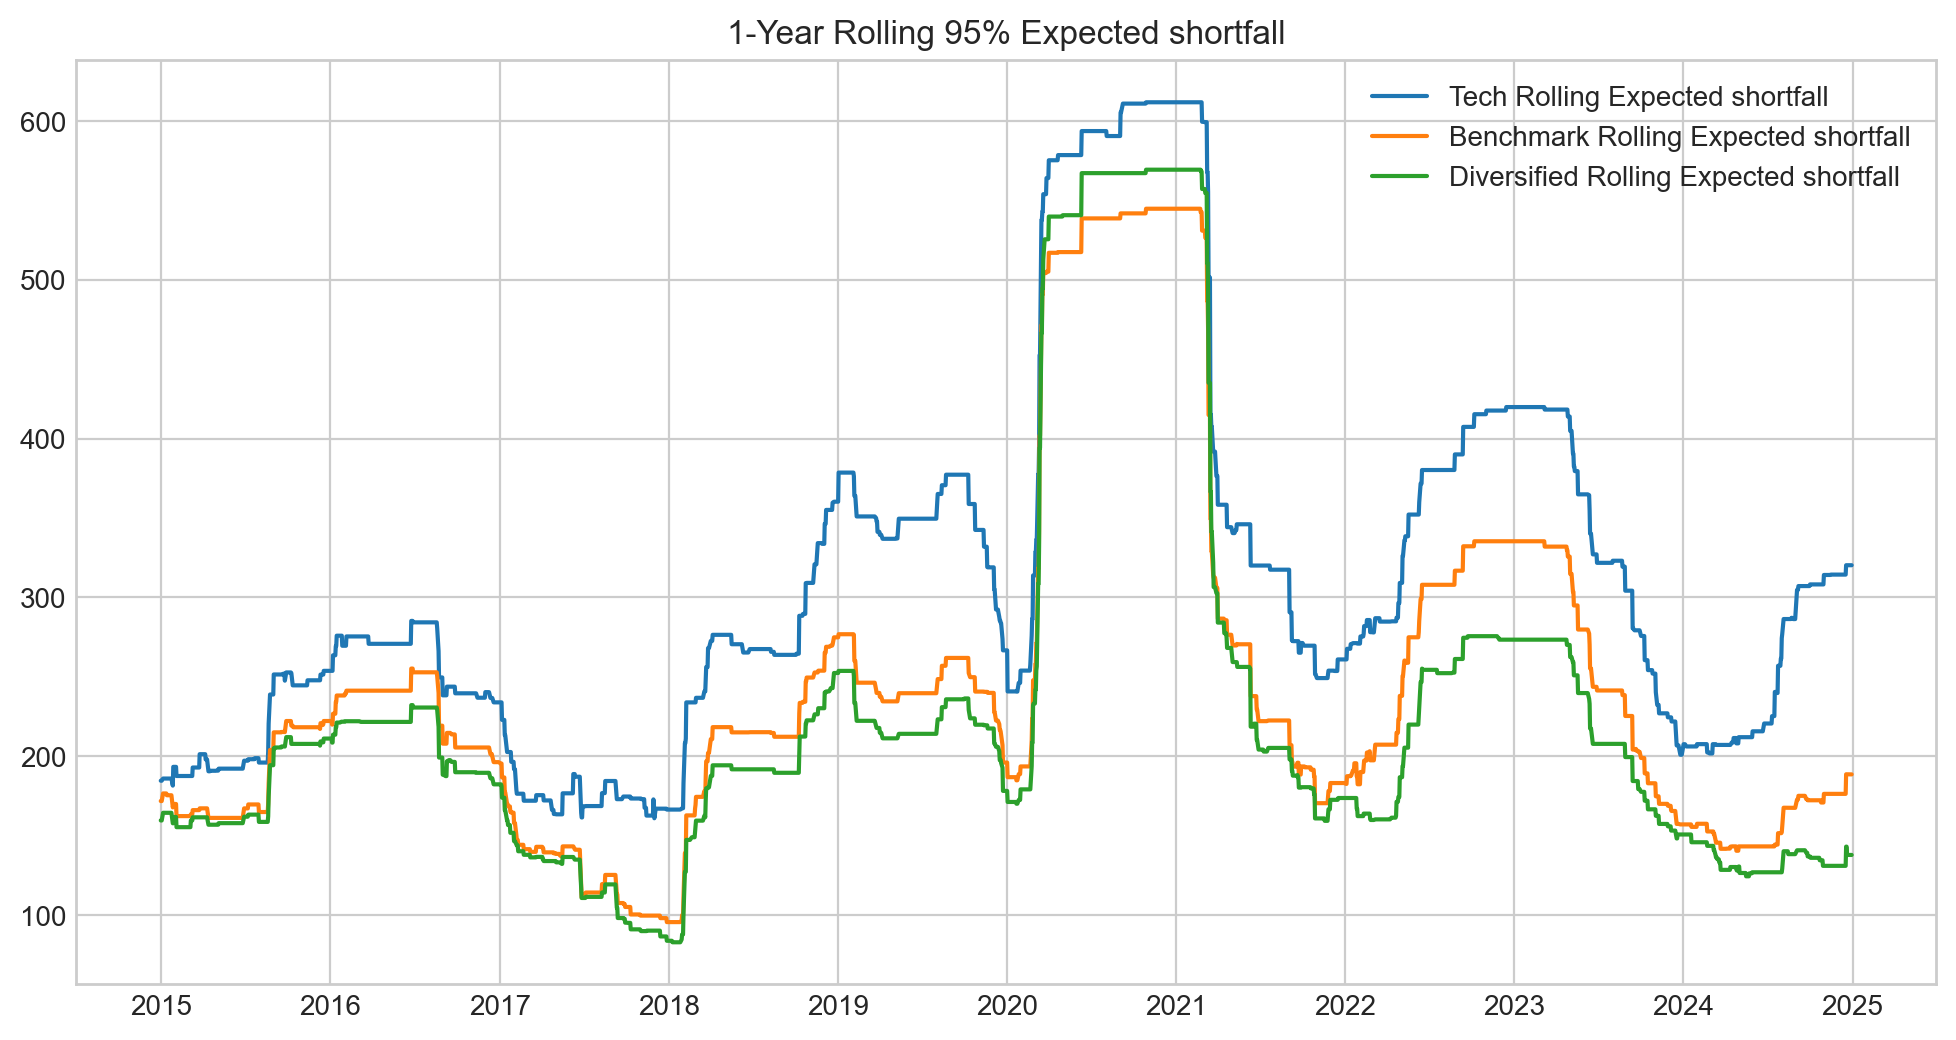

In [66]:
#historical Expected shortfall/Conditional VaR

tech_rolling_es = initial_capital * tech_rolling_returns.apply(lambda x: -x[x <= np.percentile(x, 5)].mean())
bench_rolling_es = initial_capital * bench_rolling_returns.apply(lambda x: -x[x <= np.percentile(x, 5)].mean())
div_rolling_es = initial_capital * div_rolling_returns.apply(lambda x: -x[x <= np.percentile(x, 5)].mean())


plt.plot(tech_rolling_es, label = 'Tech Rolling Expected shortfall')
plt.plot(bench_rolling_es, label = 'Benchmark Rolling Expected shortfall')
plt.plot(div_rolling_es, label = 'Diversified Rolling Expected shortfall')
plt.title('1-Year Rolling 95% Expected shortfall')
plt.legend();

In [78]:
# Calculate rolling correlations between metrics
window = 252

tech_vol_var_corr = tech_rolling_volatility.corr(tech_rolling_VaR)
bench_vol_var_corr = bench_rolling_volatility.corr(bench_rolling_VaR)
div_vol_var_corr = div_rolling_volatility.corr(div_rolling_VaR)
print(f'Volatility vs VaR correlation for All-tech (XLK) portfolio: {tech_vol_var_corr:.2} \nVolatility vs VaR correlation for Benchmark (SPY) portfolio: {bench_vol_var_corr:.2} \nVolatility vs VaR correlation for Diversified portfolio: {div_vol_var_corr:.2}')


Volatility vs VaR correlation for All-tech (XLK) portfolio: 0.98 
Volatility vs VaR correlation for Benchmark (SPY) portfolio: 0.97 
Volatility vs VaR correlation for Diversified portfolio: 0.97


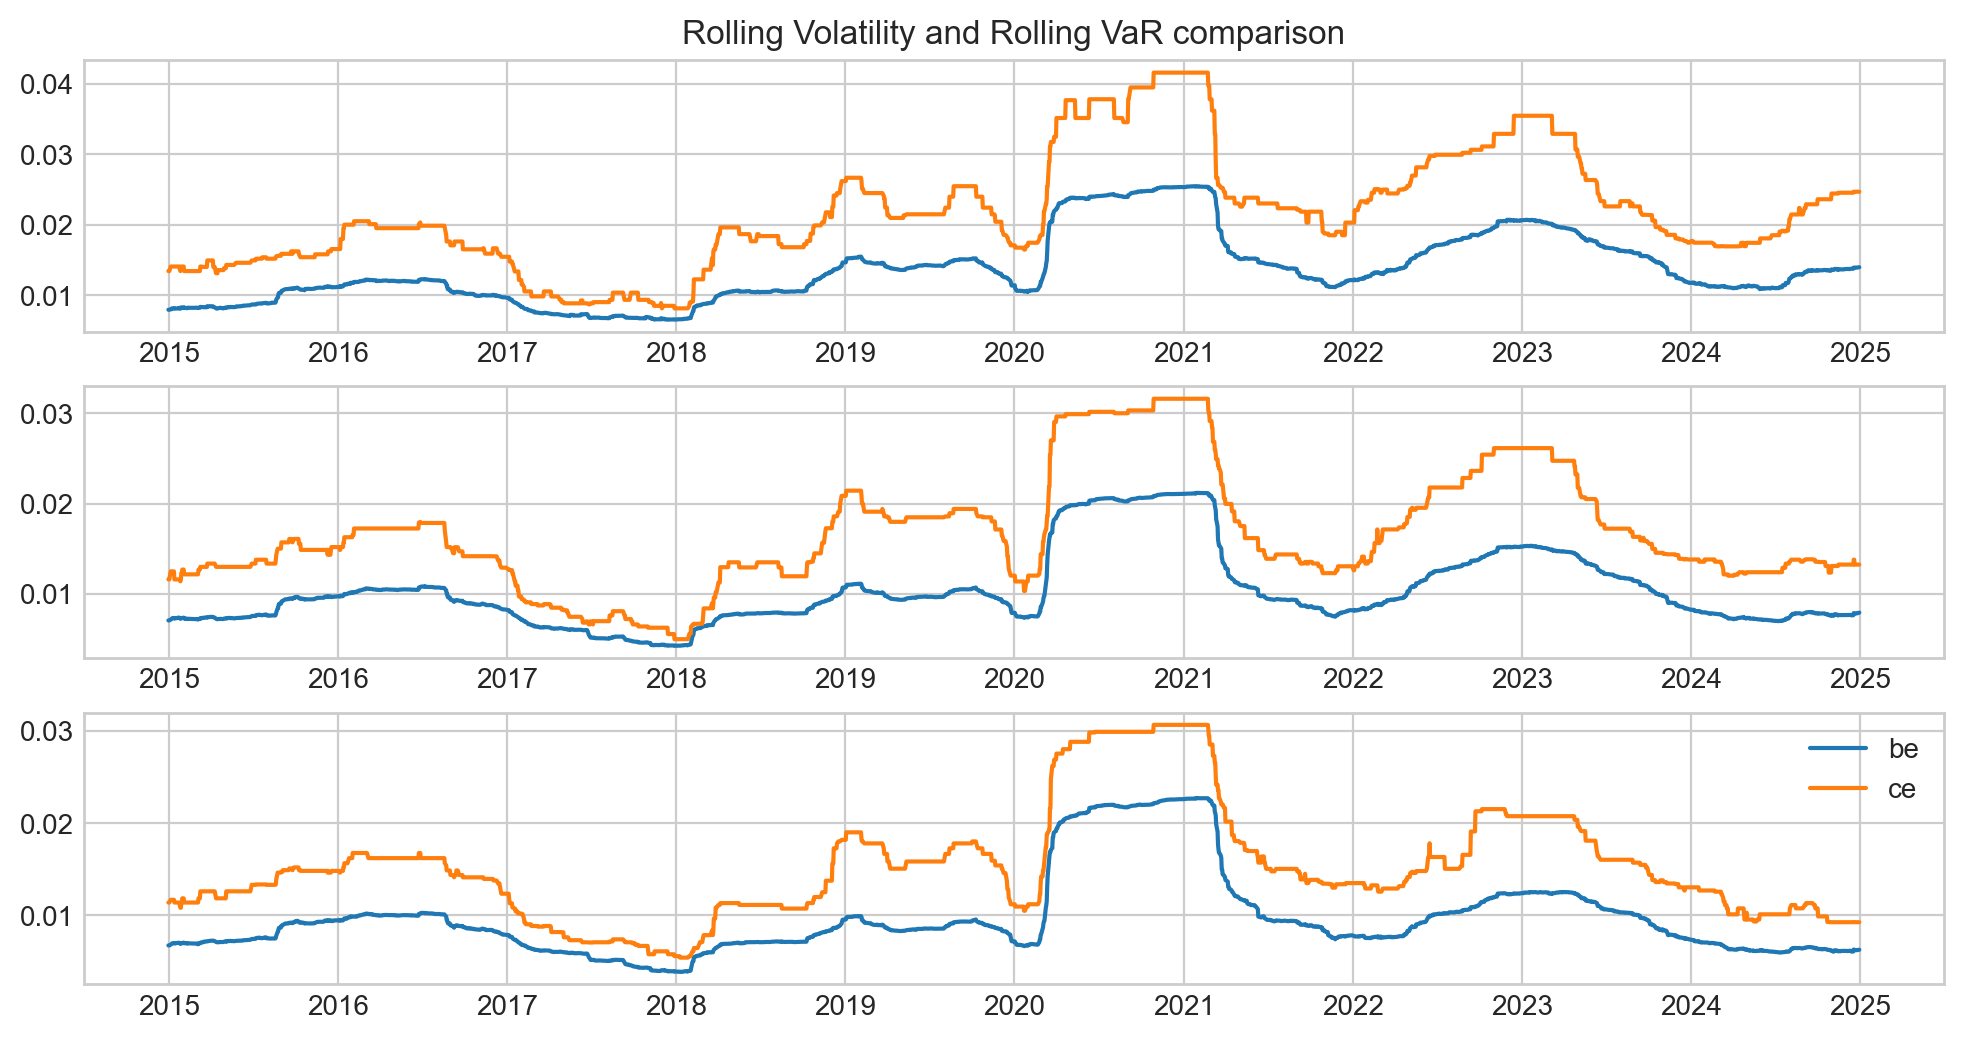

In [88]:
plt.subplot(3, 1, 1)
plt.title('Rolling Volatility and Rolling VaR comparison')
plt.plot(tech_rolling_volatility, label = 'be')
plt.plot(tech_rolling_VaR/initial_capital, label = 'ce')

plt.subplot(3, 1, 2)
plt.plot(bench_rolling_volatility, label = 'be')
plt.plot(bench_rolling_VaR/initial_capital, label = 'ce')
plt.subplot(3, 1, 3)
plt.plot(div_rolling_volatility, label = 'be')
plt.plot(div_rolling_VaR/initial_capital, label = 'ce')
plt.legend()

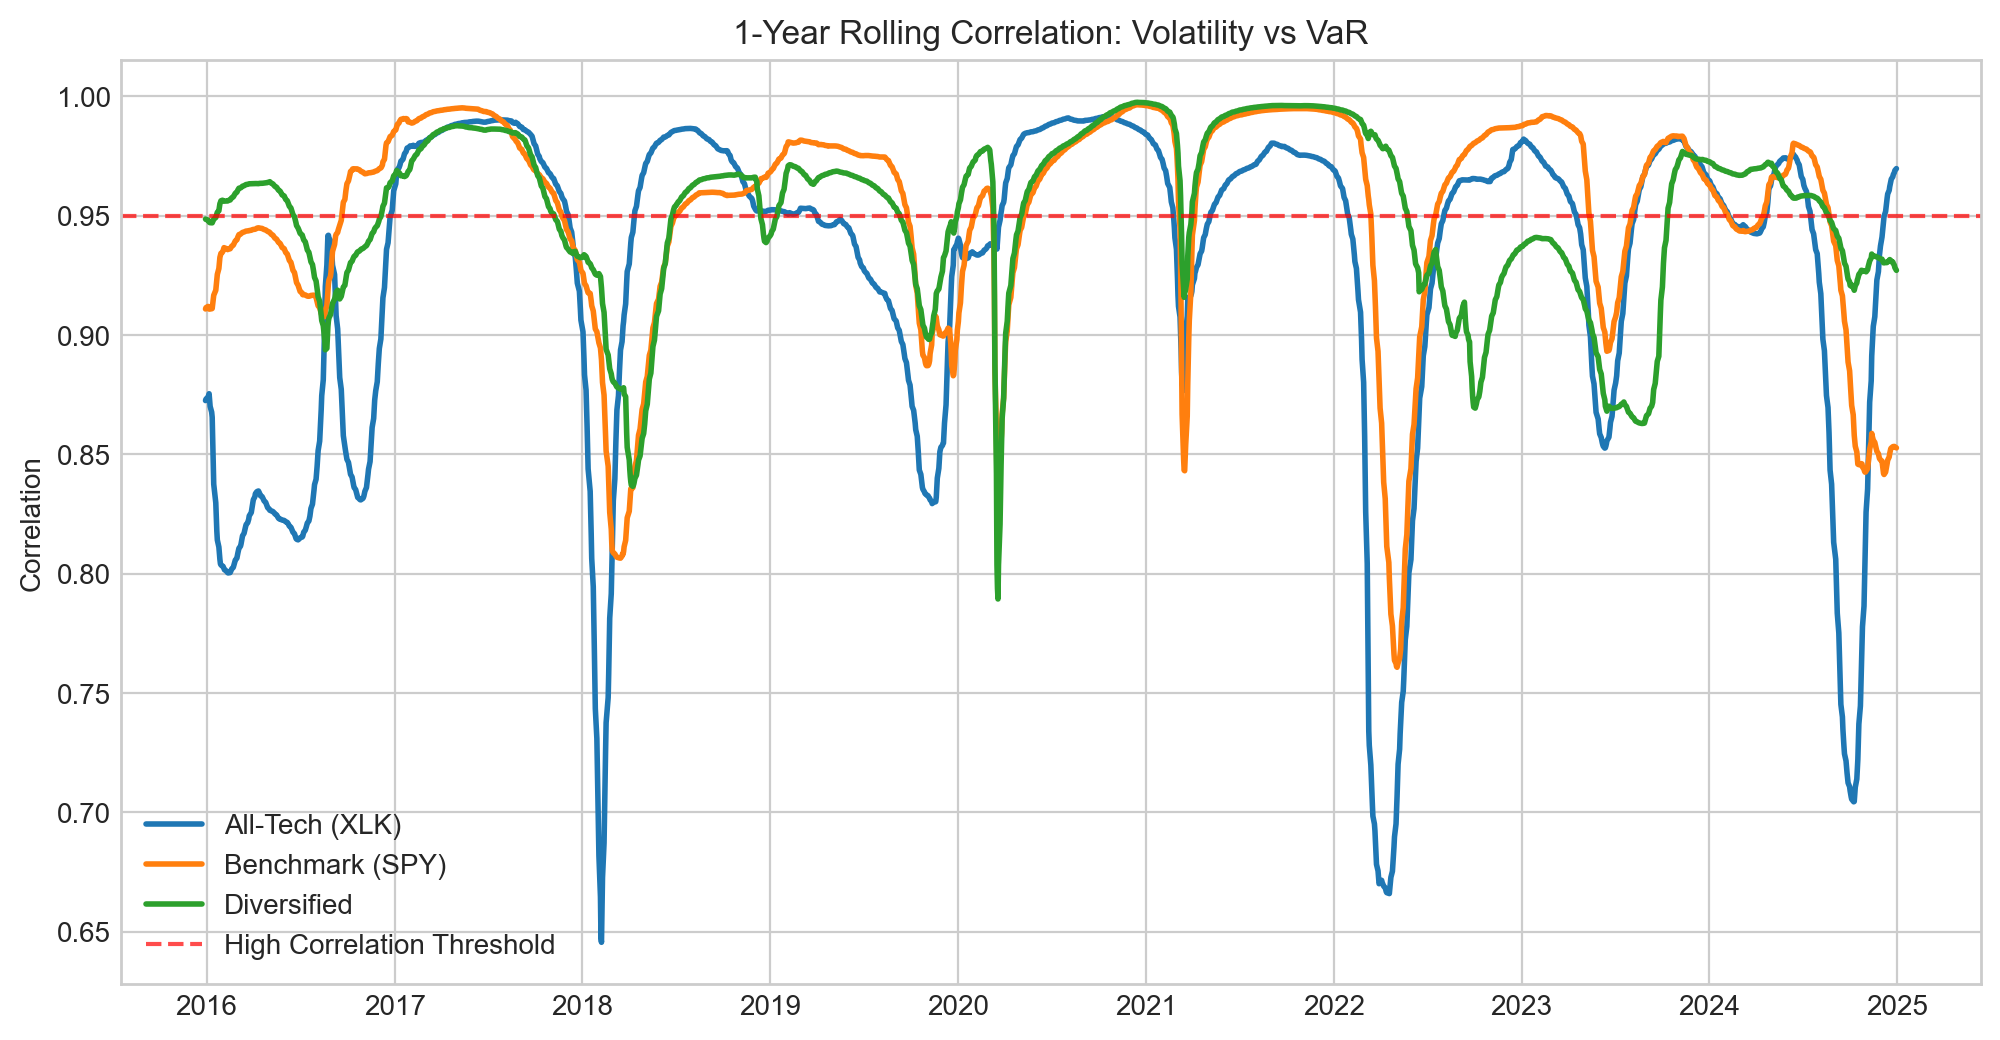

In [89]:

tech_rolling_vol_VaR_corr = tech_rolling_volatility.rolling(252).corr(tech_rolling_VaR) # .rolling().corr() is actually a way to do rolling correlation according to .corr() pandas documentation
bench_rolling_vol_VaR_corr = bench_rolling_volatility.rolling(252).corr(bench_rolling_VaR)
div_rolling_vol_VaR_corr = div_rolling_volatility.rolling(252).corr(div_rolling_VaR)

plt.plot(tech_rolling_vol_VaR_corr, label = 'All-Tech (XLK)', linewidth = 2)
plt.plot(bench_rolling_vol_VaR_corr, label = 'Benchmark (SPY)', linewidth = 2)
plt.plot(div_rolling_vol_VaR_corr, label = 'Diversified', linewidth= 2)
plt.axhline(y = 0.95, color = 'red', linestyle = '--', alpha = 0.7, label = 'High Correlation Threshold')
plt.title('1-Year Rolling Correlation: Volatility vs VaR')
plt.ylabel('Correlation')
plt.legend()
plt.show()

Let's build the covariance matrix, which allows us to quantify the relationships between the assets in the portfolio, to see what drove the defense mechanisms of diversified portfolio.
In essence, it measures how the different sector ETFs moved in relation to each other. The goal of diversification is to combine assets with low or negative covariance.

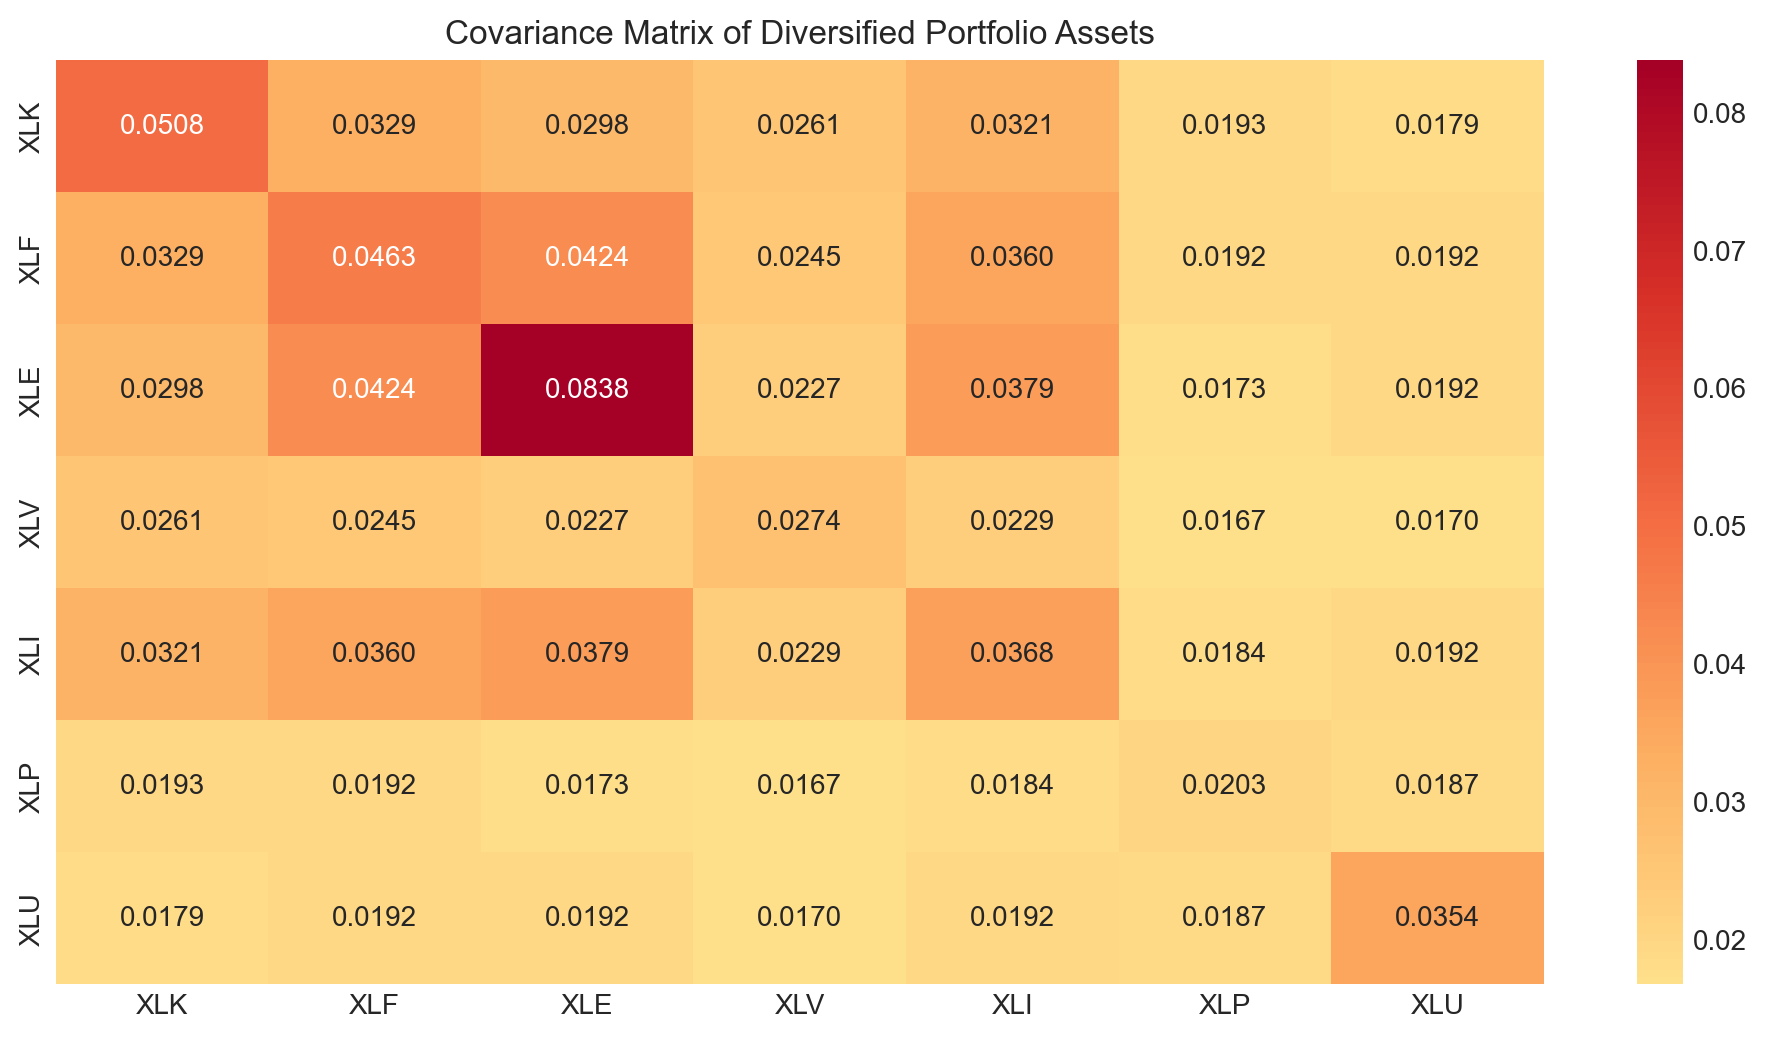

In [90]:
covariance_matrix = returns_df[div_tickers].cov()*252
sns.heatmap(covariance_matrix, 
            annot=True,
            fmt='.4f',
            cmap='RdYlGn_r',
            center=0)
plt.title('Covariance Matrix of Diversified Portfolio Assets')
plt.show()

The result is surprising: all pairwise covariances are positive. This appears to contradict classic diversification theory: if all assets move together, how can combining them reduce risk?
The universally positive covariance over this 10-year period is likely influenced by correlation regime shifts, particularly the extreme market stress of the March 2020 COVID-19 crash. During such systemic panics, correlations between all risky assets spike towards +1. This short-term event can dominate the calculation of a long-term average.

This highlights why professionals often avoid using a single, full-period covariance matrix for forward-looking analysis. It may overstate the average interconnectedness by giving equal weight to a brief crisis period and years of normal market behavior. The protection seen in 2022 suggests that under normal—or sector-specific stress—conditions, the diversifying relationships between these assets are more effective than this long-term matrix implies.

In [91]:
correlation_matrix_pearson = returns_df[div_tickers].corr(method = 'pearson')
correlation_matrix_spearman = returns_df[div_tickers].corr(method = 'spearman')
difference = (correlation_matrix_pearson - correlation_matrix_spearman).abs().mean().mean()
print(f"Average absolute difference between Pearson and Spearman: {difference:.4f}")

Average absolute difference between Pearson and Spearman: 0.1036


The Pearson correlations are systematically higher than the Spearman correlations by an average of 0.104. This indicates that while the relationships between sector ETFs are strongly linear, they contain non-linear noise that reduces the perfect monotonic alignment. This supports the use of Pearson correlation for portfolio optimization.

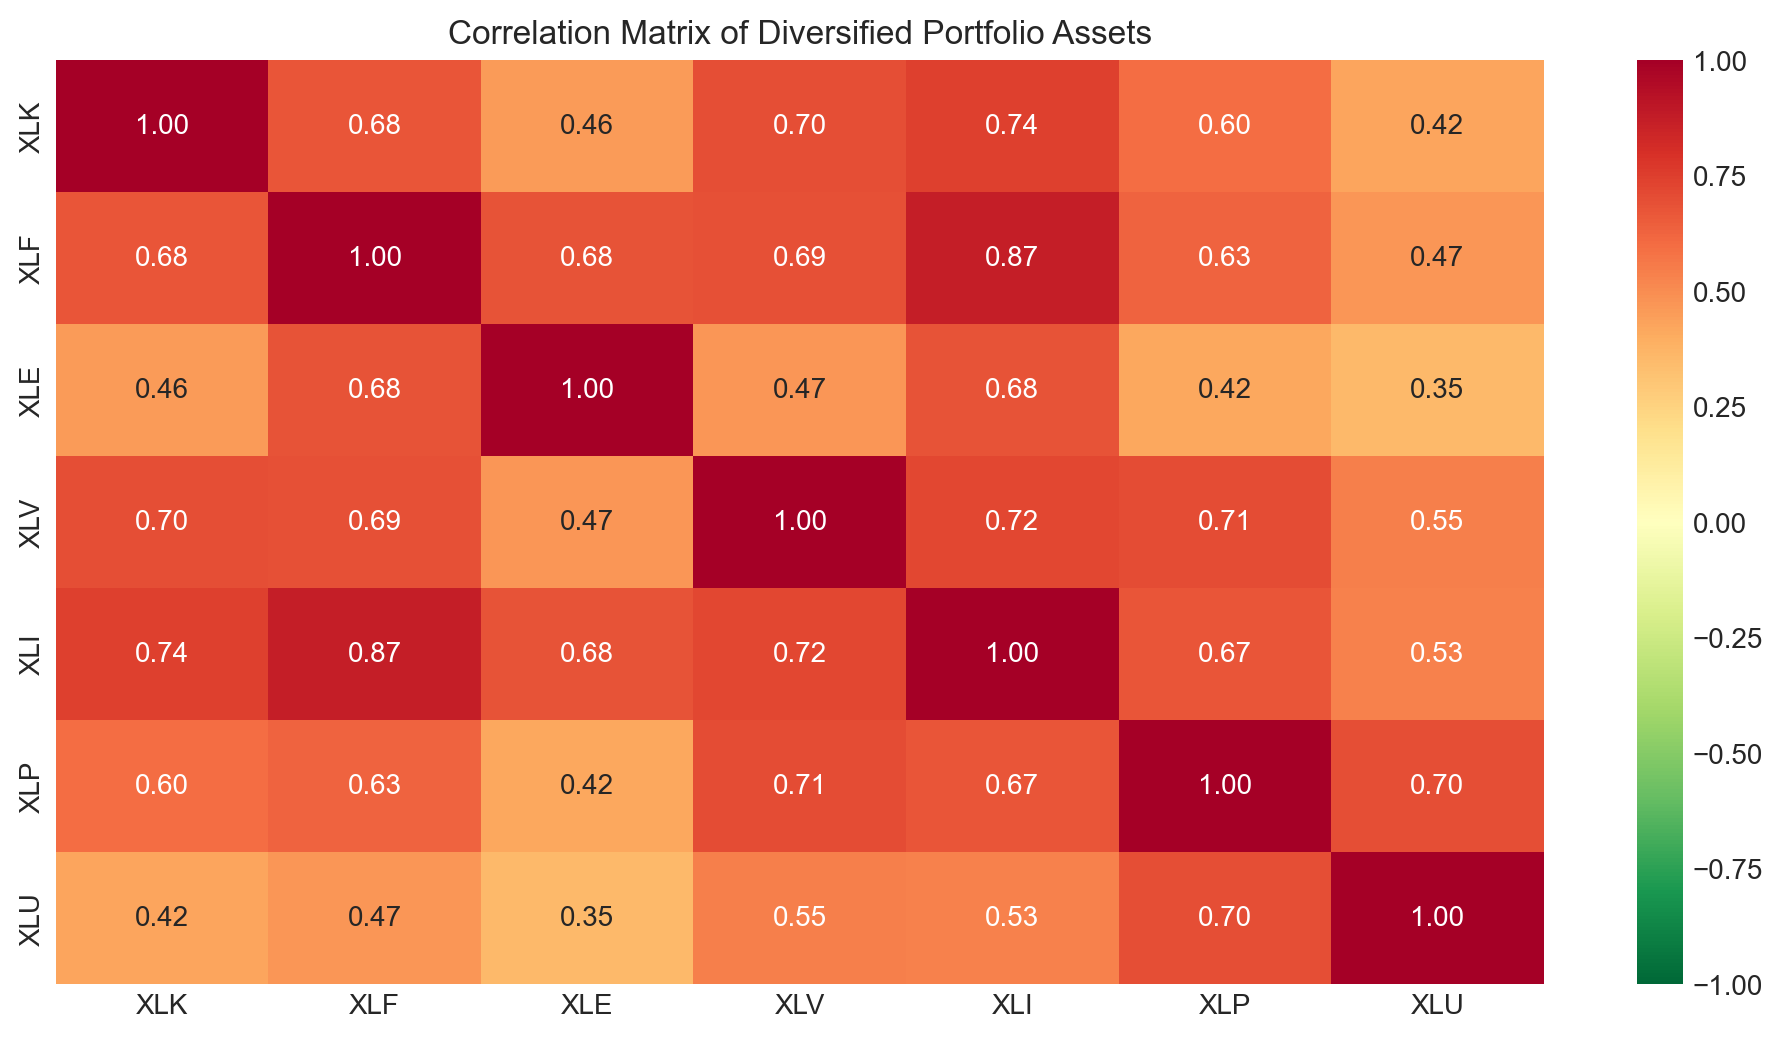

In [95]:
correlation_matrix = correlation_matrix_pearson
sns.heatmap(correlation_matrix, 
            annot=True,
            fmt='.2f',
            cmap='RdYlGn_r',
            center=0,
            vmin=-1,
            vmax=1)
plt.title('Correlation Matrix of Diversified Portfolio Assets')
plt.show()

By plotting correlation matrix we can at least compare the assets dependencies over the longer period. While all correlations are positive—confirming that these sectors are driven by a common market factor—the relative differences are what created the diversification benefit.
The Technology sector (XLK) shows a notably lower correlation with defensive sectors like Utilities (XLU, 0.42) and Energy (XLE, 0.46). In contrast, it moves much more closely with cyclical sectors like Industrials (XLI, 0.74).
This is the mechanism behind the 2022 bear market resilience: as rising interest rates hammered technology stocks, the portfolio's allocations to the less-rate-sensitive Utilities and Energy sectors provided a crucial offset. The diversification worked not because sectors moved in opposite directions, but because they had different sensitivities to the specific macroeconomic shock of 2022.

In [38]:
comparison = pd.DataFrame({
    'Pair': ['XLK-XLU', 'XLK-XLI', 'XLK-XLE'],
    'Pearson': [correlation_matrix_pearson.loc['XLK', 'XLU'], correlation_matrix_pearson.loc['XLK', 'XLI'], correlation_matrix_pearson.loc['XLK', 'XLE']],
    'Spearman': [correlation_matrix_spearman.loc['XLK', 'XLU'], correlation_matrix_spearman.loc['XLK', 'XLI'], correlation_matrix_spearman.loc['XLK', 'XLE']],
    'Difference': [correlation_matrix_spearman.loc['XLK', 'XLU'] - correlation_matrix_pearson.loc['XLK', 'XLU'], 
                   correlation_matrix_spearman.loc['XLK', 'XLI'] - correlation_matrix_pearson.loc['XLK', 'XLI'],
                   correlation_matrix_spearman.loc['XLK', 'XLE'] - correlation_matrix_pearson.loc['XLK', 'XLE']]
})
print(comparison)

      Pair   Pearson  Spearman  Difference
0  XLK-XLU  0.422583  0.263002   -0.159581
1  XLK-XLI  0.742474  0.652861   -0.089613
2  XLK-XLE  0.457038  0.351783   -0.105256


For example, the significant difference between Pearson (0.42) and Spearman (0.26) correlations for the XLK-XLU pair is particularly noticable. This suggests that while Technology and Utilities exhibit a moderate linear relationship during normal market conditions, their rank-order relationship is much weaker. They may move together in calm markets (captured by Pearson), but during stress periods or major trends, their performance ranking becomes less predictable (captured by the lower Spearman). This is exactly the type of nuanced relationship that effective diversification seeks to capture—assets that behave differently when it matters most.

Correlations Across Market Regimes:
Pair          XLK-XLE  XLK-XLF  XLK-XLI  XLK-XLP  XLK-XLU  XLK-XLV
Regime                                                            
COVID Crisis     0.63     0.77     0.79     0.82     0.72     0.86
Post-COVID       0.24     0.58     0.68     0.43     0.30     0.56
Pre-COVID        0.55     0.71     0.78     0.58     0.26     0.72


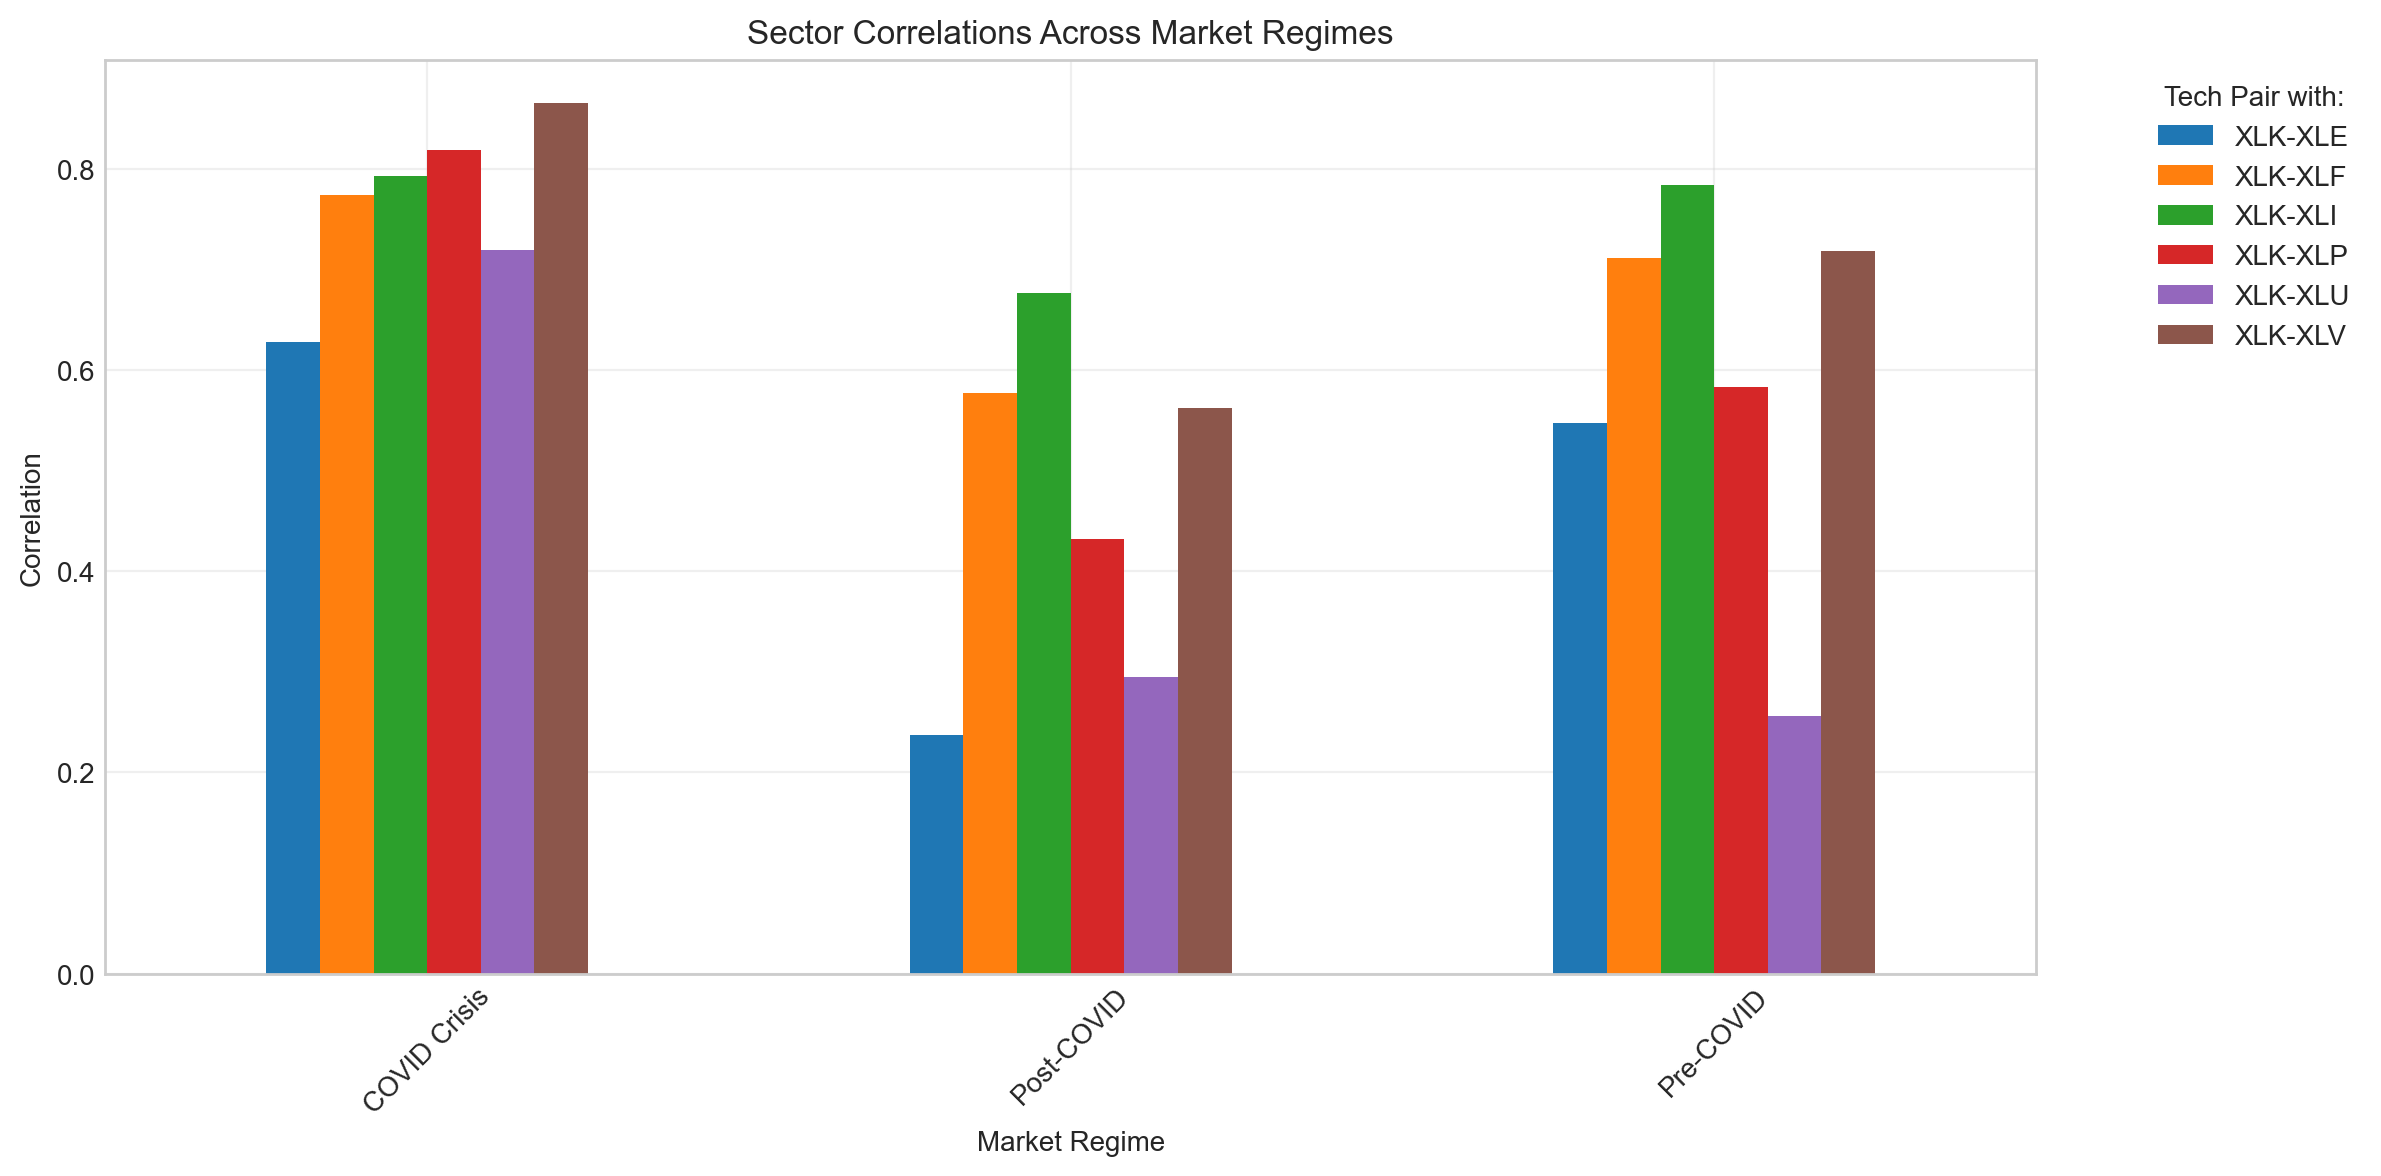

In [106]:

regimes = {
    'Pre-COVID': ('2014-01-01', '2019-12-31'),
    'COVID Crisis': ('2020-01-01', '2020-12-31'), 
    'Post-COVID': ('2021-01-01', '2024-12-31')
}

#all paris with tech sector
key_pairs = [('XLK', 'XLU'), ('XLK', 'XLE'), ('XLK', 'XLP'), ('XLK', 'XLI'), ('XLK', 'XLF'), ('XLK', 'XLV')]

regime_results = []
for regime_name, (start, end) in regimes.items():
    regime_returns = returns_df.loc[start:end, div_tickers]
    regime_corr = regime_returns.corr(method = 'pearson')
    
    for pair in key_pairs:
        corr = regime_corr.loc[pair[0], pair[1]]
        regime_results.append({
            'Regime': regime_name,
            'Pair': f'{pair[0]}-{pair[1]}',
            'Correlation': corr
        })

# Create comparison DataFrame
regime_df = pd.DataFrame(regime_results)
pivot_regime = regime_df.pivot(index='Regime', columns='Pair', values='Correlation')

print("Correlations During Different Market Regimes:")
print(pivot_regime.round(2))

# Plot with periods on X-axis and pairs in legend
pivot_regime.plot(kind='bar')
plt.title('Sector Correlations Across Market Regimes')
plt.ylabel('Correlation')
plt.xlabel('Market Regime')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.legend(title='Tech Pair with:', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Having seen how the assets relate, we can now map the entire universe of possible portfolios they can form. The Efficient Frontier will show us the spectrum of risk-return trade-offs and reveal how efficient our simple equal-weight strategy was compared to all other possible combinations. 
Efficient Frontier was constructed using a Monte Carlo simulation first for buy and hold strategies only requiring much less computation power. Using historical annualized returns and the covariance matrix of the seven sector ETFs, 50,000 random portfolios were generated by creating random weight combinations that sum to 1.

In [20]:
#efficient frontier calculations
ef_expected_returns = returns_df[div_tickers].mean() * 252
np.random.seed(41) #lock in the random number so the plot looks always the same
num_port = 50000
ef_all_weights_arr = np.zeros((num_port, len(div_tickers)))
ef_returns_arr = np.zeros(num_port)
ef_vol_arr = np.zeros(num_port)
ef_sharpe_arr = np.zeros(num_port)

for i in range(num_port):
    ef_weights = np.random.random(len(div_tickers))
    ef_weights /= np.sum(ef_weights)
    
    ef_all_weights_arr[i,:] = ef_weights
    ef_returns_arr[i] = np.sum(np.multiply(ef_expected_returns, ef_weights))
    ef_vol_arr[i] = np.sqrt(np.dot(ef_weights.T, np.dot(covariance_matrix, ef_weights)))
    ef_sharpe_arr[i] = (ef_returns_arr[i] - average_tnx_yield)/ef_vol_arr[i]

In [21]:
print(f'Max Sharpe Ratio for diversified portfolios: {ef_sharpe_arr.max():.2}')
print('Target weights for achieving max Sharpe Ratio in the diversified portfolio: ')
for i in range(len(div_tickers)):
    print(f'{div_tickers[i]} {ef_all_weights_arr[ef_sharpe_arr.argmax(),i]:.2}')
max_sr_vol = ef_vol_arr[ef_sharpe_arr.argmax()]
max_sr_returns = ef_returns_arr[ef_sharpe_arr.argmax()]

Max Sharpe Ratio for diversified portfolios: 0.81
Target weights for achieving max Sharpe Ratio in the diversified portfolio: 
XLK 0.57
XLF 0.035
XLE 0.0052
XLV 0.043
XLI 0.045
XLP 0.083
XLU 0.22


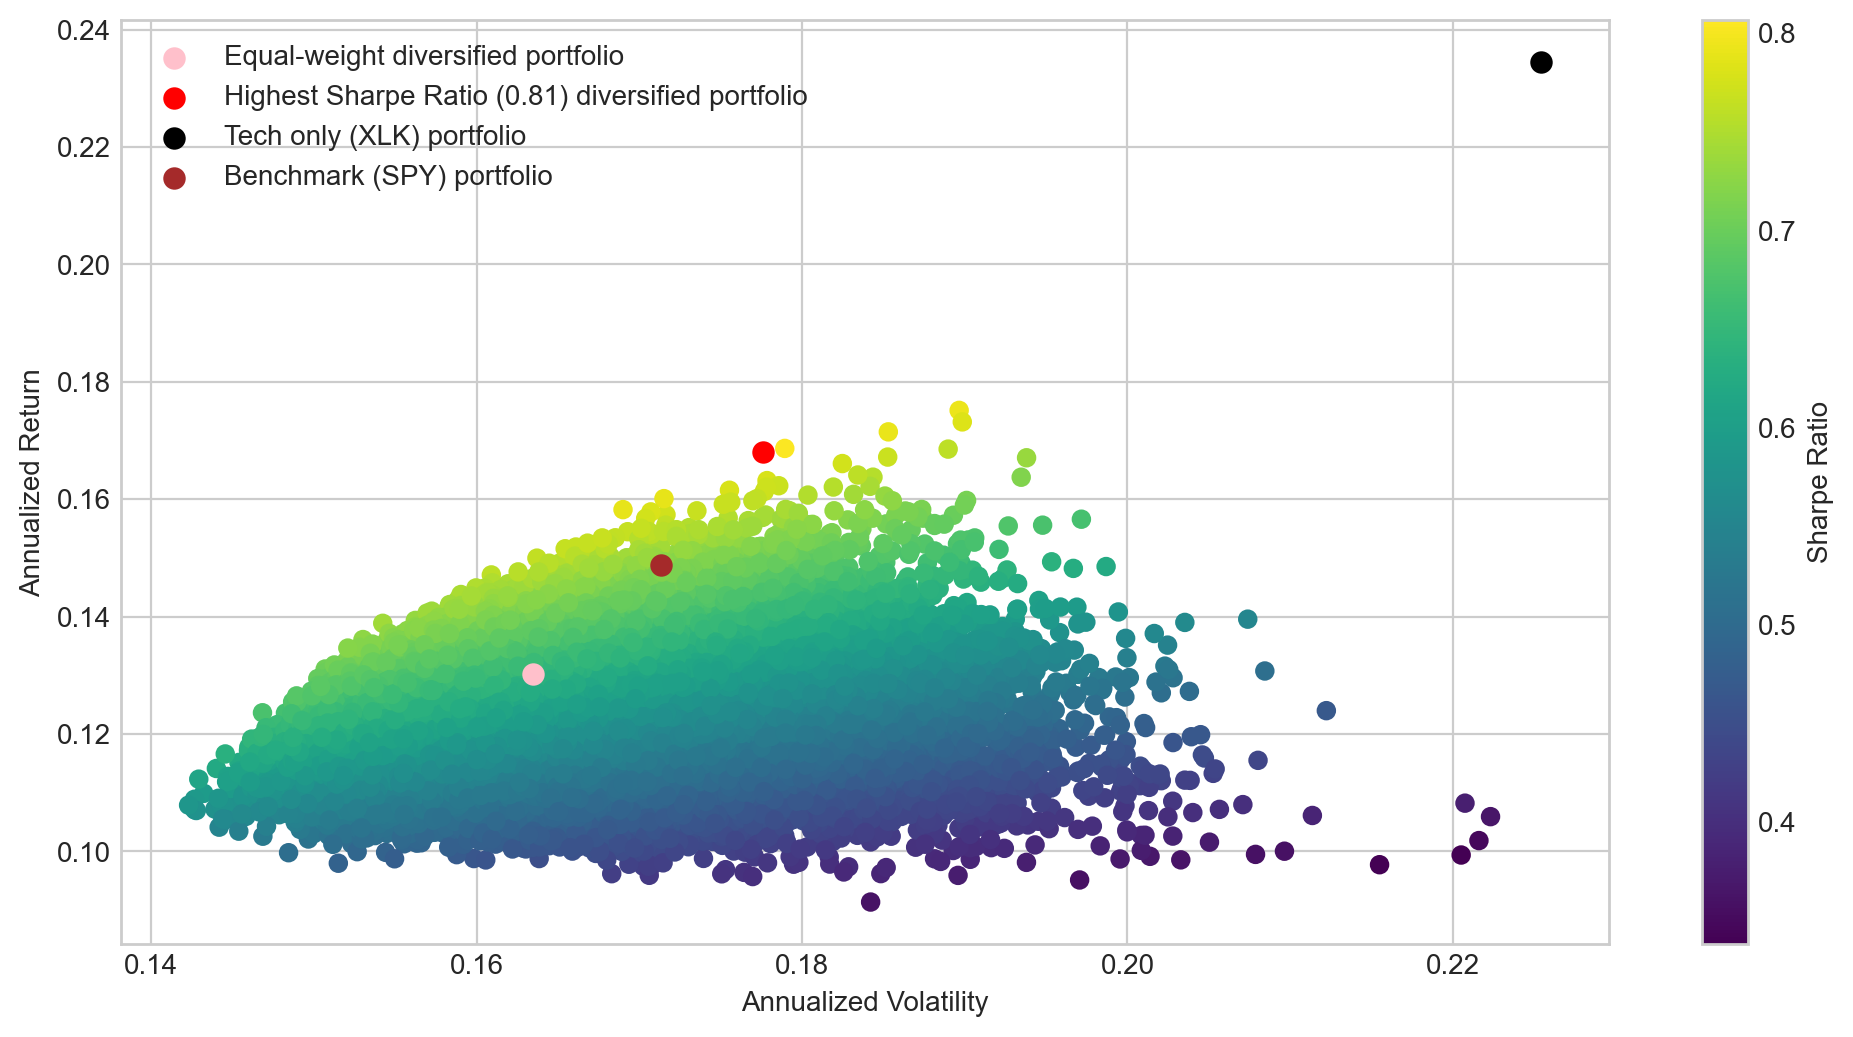

In [22]:
plt.scatter(ef_vol_arr, ef_returns_arr, c = ef_sharpe_arr, cmap = 'viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.scatter(div_annual_volatility, div_annualized_return, c = "pink", s = 50, label = 'Equal-weight diversified portfolio')
plt.scatter(max_sr_vol, max_sr_returns,c = 'red', s = 50, label = 'Highest Sharpe Ratio (0.81) diversified portfolio')
plt.scatter(tech_annual_volatility, tech_annualized_return, c = "black", s = 50, label = 'Tech only (XLK) portfolio')
plt.scatter(bench_annual_volatility, bench_annualized_return, c = "brown", s = 50, label = 'Benchmark (SPY) portfolio')
plt.legend()
plt.show()

Next a quarterly_rebalancing function was used to simulate random portfolios which weights are actually kept during the analyzed period. This however is computation-heavy task, with 1000 portfolios simulating for 30 minutes. While computationally intensive, this method has the advantage of being conceptually straightforward and accurately modeling the rebalancing process. Professional implementations would typically use quadratic programming optimizers for faster results, but the Monte Carlo approach provides identical results while being more transparent for educational purposes. One should also reconsider using differnt programming languages for such task.

In [29]:
#Efficient frontier calculations WITH REBALANCING
np.random.seed(41)
num_port = 1000  # 1000 portfolios simulates in 30min
ef_returns_arr_rebalanced = np.zeros(num_port)
ef_vol_arr_rebalanced = np.zeros(num_port)
ef_sharpe_arr_rebalanced = np.zeros(num_port)
ef_weights_arr_rebalanced = np.zeros((num_port, len(div_tickers)))

for i in range(num_port):
    ef_weights = np.random.random(len(div_tickers))
    ef_weights /= np.sum(ef_weights)
    ef_weights_arr_rebalanced[i,:] = ef_weightsk
    
    equity, returns = quarterly_rebalancing(returns_df, div_tickers, ef_weights, initial_capital = 10000)
    
    final_value = equity.iloc[-1]
    num_years = (equity.index[-1] - equity.index[0]).days / 365.25
    cagr = (final_value / 10000) ** (1/num_years) - 1
    annual_vol = returns.std() * np.sqrt(252)
    
    ef_returns_arr_rebalanced[i] = cagr
    ef_vol_arr_rebalanced[i] = annual_vol
    ef_sharpe_arr_rebalanced[i] = (cagr - average_tnx_yield) / annual_vol

print(f'Max Sharpe Ratio for REBALANCED diversified portfolios: {ef_sharpe_arr_rebalanced.max():.2f}')
print('Target weights for achieving max Sharpe Ratio in the REBALANCED diversified portfolio: ')
for i in range(len(div_tickers)):
    print(f'{div_tickers[i]}: {ef_weights_arr_rebalanced[ef_sharpe_arr_rebalanced.argmax(),i]:.2f}')

max_sr_vol_rebalanced = ef_vol_arr_rebalanced[ef_sharpe_arr_rebalanced.argmax()]
max_sr_returns_rebalanced = ef_returns_arr_rebalanced[ef_sharpe_arr_rebalanced.argmax()]



Max Sharpe Ratio for REBALANCED diversified portfolios: 0.72
Target weights for achieving max Sharpe Ratio in the REBALANCED diversified portfolio: 
XLK: 0.42
XLF: 0.08
XLE: 0.04
XLV: 0.10
XLI: 0.00
XLP: 0.01
XLU: 0.36


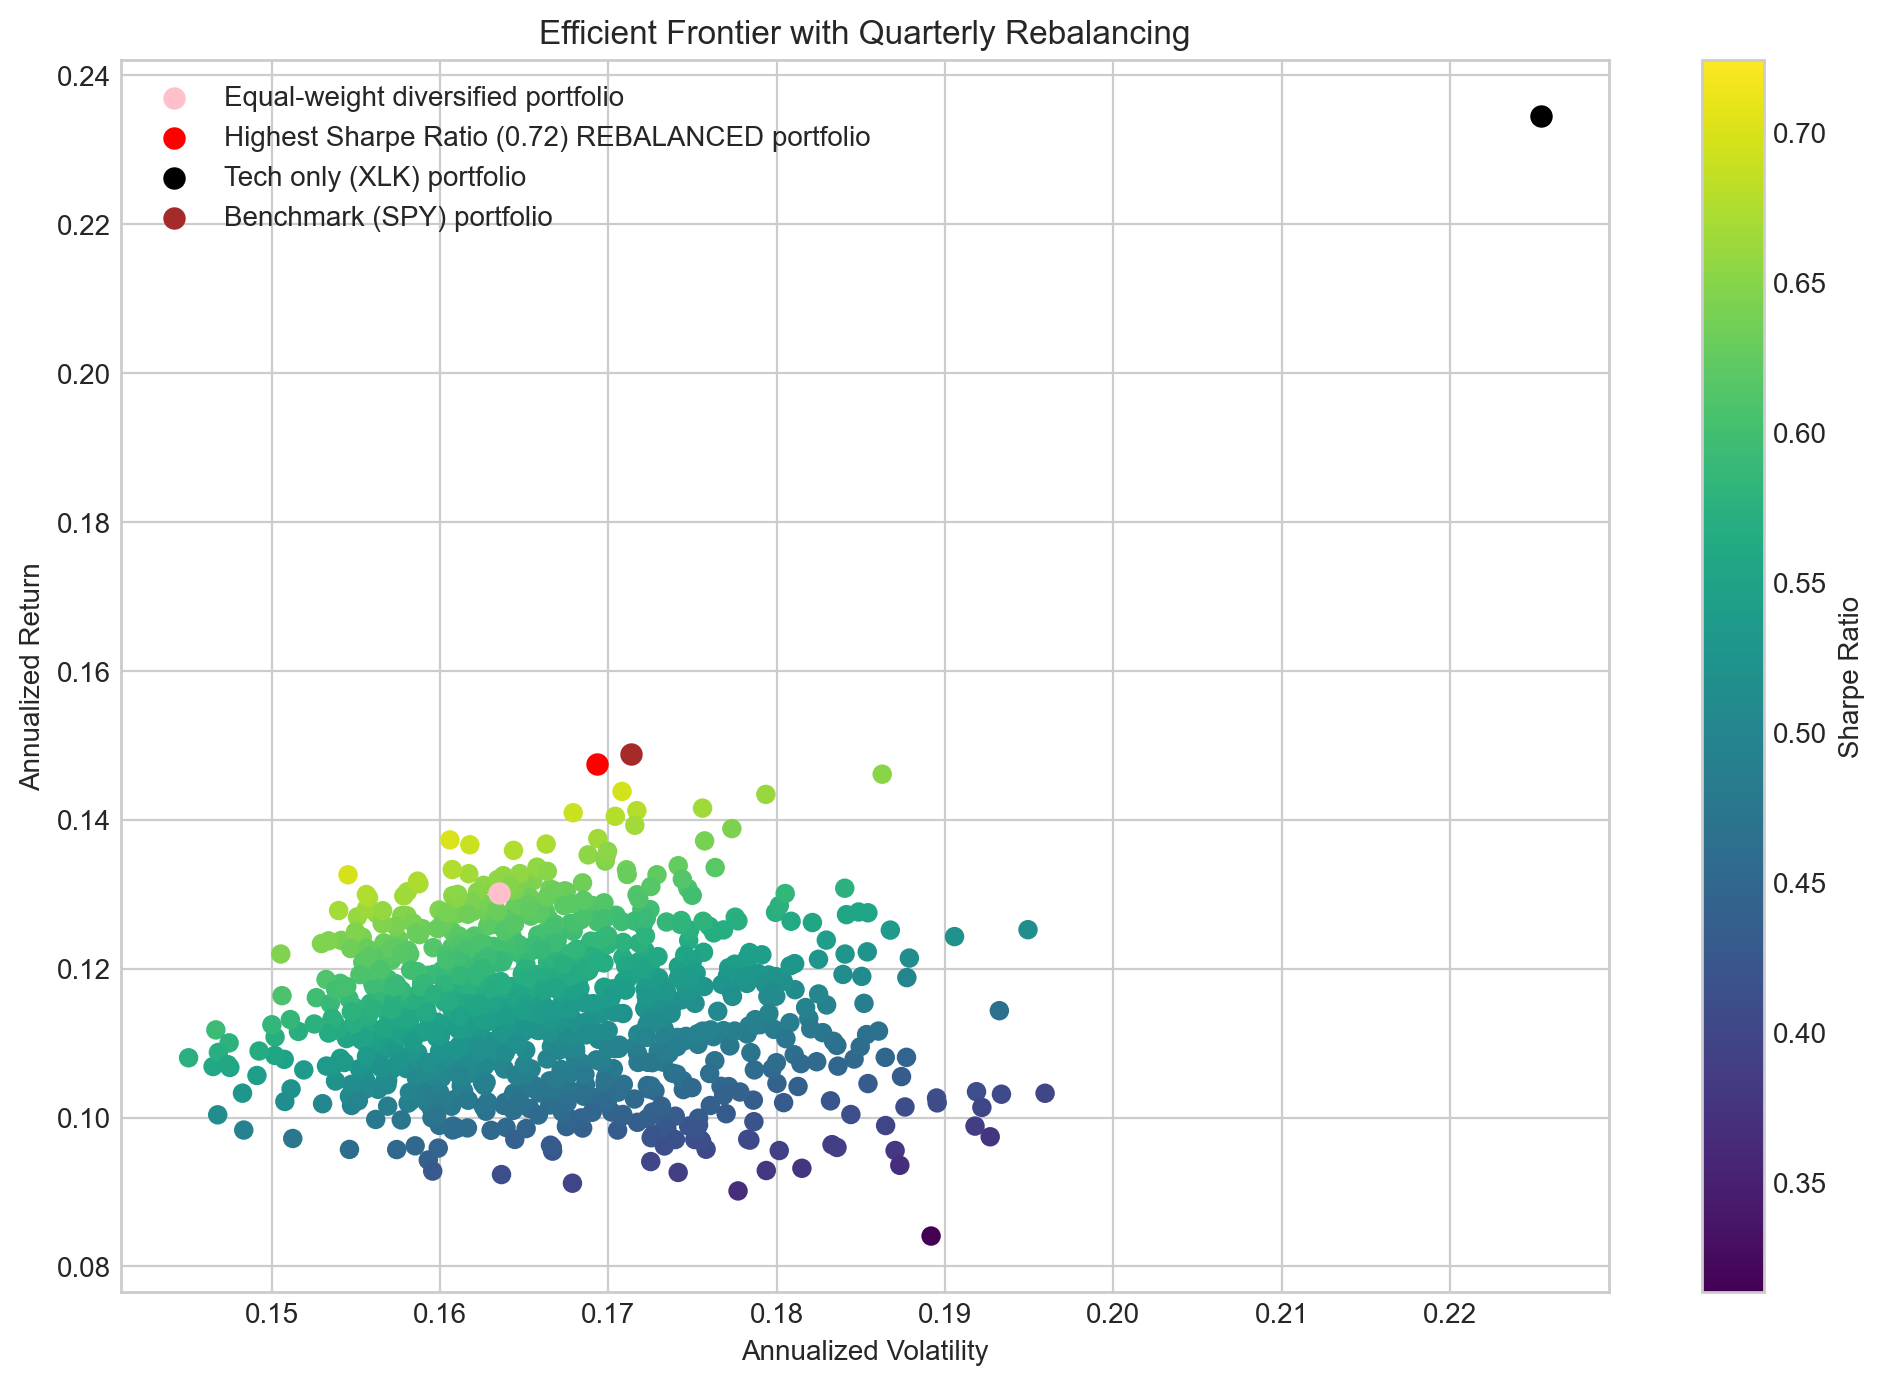

In [30]:
# Plot the REBALANCED efficient frontier
plt.scatter(ef_vol_arr_rebalanced, ef_returns_arr_rebalanced, c=ef_sharpe_arr_rebalanced, cmap='viridis')
plt.colorbar(label = 'Sharpe Ratio')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')

# Plot key portfolios (you'll need to calculate the rebalanced versions of these)
plt.scatter(div_annual_volatility, div_annualized_return, c="pink", s=50, label='Equal-weight diversified portfolio')
plt.scatter(max_sr_vol_rebalanced, max_sr_returns_rebalanced, c='red', s=50, label=f'Highest Sharpe Ratio ({ef_sharpe_arr_rebalanced.max():.2f}) REBALANCED portfolio')
plt.scatter(tech_annual_volatility, tech_annualized_return, c="black", s=50, label='Tech only (XLK) portfolio')
plt.scatter(bench_annual_volatility, bench_annualized_return, c="brown", s=50, label='Benchmark (SPY) portfolio')

plt.legend()
plt.title('Efficient Frontier with Quarterly Rebalancing')
plt.show()

The Efficient Frontier analysis maps the spectrum of risk-return trade-offs available from the selected sector ETFs. The frontier for static, buy-and-hold portfolios was generated via a Monte Carlo simulation of 50,000 random weight combinations, revealing a maximum achievable Sharpe ratio of 0.81. This high efficiency was largely an artifact of the methodology, as it allowed winning positions—primarily in technology (XLK)—to grow unchecked, effectively creating a concentrated bet that benefited from hindsight.

A more realistic assessment was achieved by simulating 1,000 portfolios using a quarterly rebalancing strategy, a computationally intensive but conceptually transparent process. This rebalanced frontier showed a maximum Sharpe ratio of 0.72, with the optimal portfolio shifting towards a more balanced allocation including significant defensive exposure (36% Utilities). This demonstrates that incorporating realistic strategy mechanics and transaction costs meaningfully impacts optimal allocation decisions.

Notably, this Monte Carlo approach, relying purely on random weight generation and without employing complex optimization algorithms, successfully identified portfolios with significantly improved efficiency over a simple equal-weight strategy (Sharpe 0.64). This underscores that even basic, methodical portfolio construction can yield substantial improvements. The equal-weight strategy served as a robust, middle-of-the-road benchmark, forgoing the potential upside of optimized concentrations while avoiding the risks of extreme bets.

## Conclusion

I am very pleased with rsults of this analysis, it helped me greatly to achieve better understanding of.. and that it's not so obvious .. risk-return dynamics ... one has to be careful .. it all depends on the risk one has to take ... my initial hypothesis turned not to be absolutely true ...